In [868]:
# Base Libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (20, 8)})

from functools import partial

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Collection
import yfinance as yf

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, TimeSeriesSplit)
from sklearn.feature_selection import VarianceThreshold

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score , classification_report , confusion_matrix

# Metrics
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             RocCurveDisplay,
                             confusion_matrix)

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

# Report generation tool
import quantstats as qs

# addition tool
import pandas_ta as ta
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

## Import and Observe data <br>
download data from yfinance and trim the data to begin with the same date.<br>
the pecentage change with calculated based on continueously compound basis.

In [869]:
# asset_list = ['CIMBT.BK','LH.BK','BAM.BK']
asset_list = ['HANA.BK','BAY.BK','ADVANC.BK']

df = yf.download(tickers=asset_list, period='max', interval='1d')
df.dropna(inplace=True)
df = df[-3650:]

df.tail(10)

[*********************100%***********************]  3 of 3 completed


Price          Close                            High                        \
Ticker     ADVANC.BK     BAY.BK    HANA.BK ADVANC.BK     BAY.BK    HANA.BK   
Date                                                                         
2025-03-25     275.0  22.799999  16.700001     275.0  22.900000  17.100000   
2025-03-26     272.0  22.900000  16.799999     278.0  22.900000  17.200001   
2025-03-27     275.0  22.900000  17.000000     276.0  23.000000  17.000000   
2025-03-28     273.0  22.799999  16.500000     275.0  22.900000  16.900000   
2025-03-31     275.0  22.700001  15.900000     275.0  22.700001  16.299999   
2025-04-01     281.0  22.500000  15.800000     281.0  22.799999  16.200001   
2025-04-02     277.0  22.500000  16.500000     282.0  22.700001  16.600000   
2025-04-03     278.0  22.600000  16.600000     280.0  22.600000  16.600000   
2025-04-04     272.0  22.299999  15.600000     278.0  22.600000  16.299999   
2025-04-08     269.0  21.400000  14.900000     272.0  22.100000  15.200000   

Price            Low                            Open                        \
Ticker     ADVANC.BK     BAY.BK    HANA.BK ADVANC.BK     BAY.BK    HANA.BK   
Date                                                                         
2025-03-25     271.0  22.799999  16.600000     273.0  22.900000  16.900000   
2025-03-26     272.0  22.799999  16.799999     276.0  22.900000  16.799999   
2025-03-27     272.0  22.799999  16.400000     272.0  22.900000  16.700001   
2025-03-28     272.0  22.799999  16.400000     274.0  22.799999  16.900000   
2025-03-31     270.0  22.500000  15.700000     270.0  22.600000  15.700000   
2025-04-01     276.0  22.500000  15.800000     276.0  22.600000  16.100000   
2025-04-02     277.0  22.500000  15.800000     282.0  22.500000  15.900000   
2025-04-03     276.0  22.400000  16.100000     277.0  22.500000  16.400000   
2025-04-04     270.0  22.100000  15.500000     277.0  22.600000  16.299999   
2025-04-08     264.0  21.400000  14.000000     270.0  22.000000  14.600000   

Price          Volume                      
Ticker      ADVANC.BK    BAY.BK   HANA.BK  
Date                                       
2025-03-25  5286000.0  102100.0   5219300  
2025-03-26  3712200.0   26700.0   5309300  
2025-03-27  1950700.0  128300.0   6842300  
2025-03-28  1420300.0   22200.0   5638600  
2025-03-31  4151600.0  182000.0   5455600  
2025-04-01  4856200.0  182200.0   5017000  
2025-04-02  3485000.0   58000.0   7739400  
2025-04-03  3730300.0  197600.0  12110500  
2025-04-04  4825500.0  315400.0  13922400  
2025-04-08  9340403.0  258327.0  10410865

In [870]:
for i in asset_list:
    df['ln_Change', i] = ta.log_return(df['Close', i])

df.reset_index(inplace=True)
df.tail(5)

Price        Date     Close                         High             \
Ticker            ADVANC.BK     BAY.BK HANA.BK ADVANC.BK     BAY.BK   
3645   2025-04-01     281.0  22.500000    15.8     281.0  22.799999   
3646   2025-04-02     277.0  22.500000    16.5     282.0  22.700001   
3647   2025-04-03     278.0  22.600000    16.6     280.0  22.600000   
3648   2025-04-04     272.0  22.299999    15.6     278.0  22.600000   
3649   2025-04-08     269.0  21.400000    14.9     272.0  22.100000   

Price                   Low                     Open                    \
Ticker    HANA.BK ADVANC.BK BAY.BK HANA.BK ADVANC.BK BAY.BK    HANA.BK   
3645    16.200001     276.0   22.5    15.8     276.0   22.6  16.100000   
3646    16.600000     277.0   22.5    15.8     282.0   22.5  15.900000   
3647    16.600000     276.0   22.4    16.1     277.0   22.5  16.400000   
3648    16.299999     270.0   22.1    15.5     277.0   22.6  16.299999   
3649    15.200000     264.0   21.4    14.0     270.0   22.0  14.600000   

Price      Volume                     ln_Change                      
Ticker  ADVANC.BK    BAY.BK   HANA.BK   HANA.BK    BAY.BK ADVANC.BK  
3645    4856200.0  182200.0   5017000 -0.006309 -0.008850  0.021584  
3646    3485000.0   58000.0   7739400  0.043350  0.000000 -0.014337  
3647    3730300.0  197600.0  12110500  0.006042  0.004435  0.003604  
3648    4825500.0  315400.0  13922400 -0.062132 -0.013363 -0.021819  
3649    9340403.0  258327.0  10410865 -0.045910 -0.041196 -0.011091

In [871]:
correlation_matrix = df['ln_Change'].corr()

print(correlation_matrix)

Ticker      HANA.BK    BAY.BK  ADVANC.BK
Ticker                                  
HANA.BK    1.000000  0.128938   0.118565
BAY.BK     0.128938  1.000000   0.193690
ADVANC.BK  0.118565  0.193690   1.000000


In [872]:
# Candlestick Plot
fig = go.Figure()

def add_trace_candle(data, ls):
    for i in ls:
        fig.add_traces(go.Candlestick(x=data['Date'],
                                      open=data['Open', i],
                                      high=data['High', i],
                                      low=data['Low', i],
                                      close=data['Close', i],
                                      name=i))
def chart_name(name):
    fig.update_layout(
        title='Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price',
        height=800,
        xaxis_rangeslider_visible=True,)
    
add_trace_candle(df, asset_list)
chart_name('Candlestick Chart')

fig.show()

In [873]:
#Line Plot
fig = go.Figure()

def add_trace_line(data, ls):
    for i in ls:
        fig.add_traces(go.Scatter(x=data['Date'],
                                  y=data['Close', i],
                                  name=i))

add_trace_line(df, asset_list)
chart_name('Line Chart')

fig.show()

In [874]:
df.dropna(inplace=True)
df.isna().sum()
df.head(5)

Price      Ticker   
Date                    0
Close      ADVANC.BK    0
           BAY.BK       0
           HANA.BK      0
High       ADVANC.BK    0
           BAY.BK       0
           HANA.BK      0
Low        ADVANC.BK    0
           BAY.BK       0
           HANA.BK      0
Open       ADVANC.BK    0
           BAY.BK       0
           HANA.BK      0
Volume     ADVANC.BK    0
           BAY.BK       0
           HANA.BK      0
ln_Change  HANA.BK      0
           BAY.BK       0
           ADVANC.BK    0
dtype: int64

Price        Date      Close                             High             \
Ticker             ADVANC.BK     BAY.BK    HANA.BK  ADVANC.BK     BAY.BK   
1      2010-04-20  36.016964  14.482697  11.294665  36.016964  14.482697   
2      2010-04-21  35.324341  14.267611  11.144734  36.016975  14.482701   
3      2010-04-22  35.208897  14.339304  11.394616  35.786092  14.554393   
4      2010-04-23  34.978020  13.980823  11.594522  34.978020  14.052519   
5      2010-04-26  35.093452  14.052521  11.694477  35.439769  14.195913   

Price                    Low                             Open             \
Ticker    HANA.BK  ADVANC.BK     BAY.BK    HANA.BK  ADVANC.BK     BAY.BK   
1       11.344642  34.516257  13.694035  11.044783  34.516257  13.837428   
2       11.294664  35.208902  14.052521  11.144734  35.786097  14.267611   
3       11.394616  34.978019  14.195910  11.144734  34.978019  14.195910   
4       11.594522  34.400825  13.837429  11.244686  34.631703  13.980823   
5       11.894382  35.093452  13.980824  11.694477  35.439769  14.195913   

Price                 Volume                      ln_Change            \
Ticker    HANA.BK  ADVANC.BK      BAY.BK  HANA.BK   HANA.BK    BAY.BK   
1       11.144736  8342000.0  29569500.0  1592500  0.017858  0.066520   
2       11.294664  6988200.0  20454600.0   833100 -0.013363 -0.014963   
3       11.144734  5056900.0  15983100.0   558000  0.022174  0.005012   
4       11.394615  3694900.0  23853000.0  1433900  0.017392 -0.025318   
5       11.744454  2588100.0  16825000.0  1379400  0.008584  0.005115   

Price             
Ticker ADVANC.BK  
1       0.052644  
2      -0.019418  
3      -0.003273  
4      -0.006579  
5       0.003295

we will repeat the dropna again after Indicator implementation

## Adding Indicators

In [875]:
df1 = {}

# First, we create features that are common to both assets
for asset in asset_list:
  # Create features
  df1[asset] = pd.DataFrame()
  df1[asset]['Date'] =  df[('Date')]
  df1[asset]['Open'] =  df[('Open',asset)]
  df1[asset]['High'] =  df[('High',asset)]
  df1[asset]['Low'] =  df[('Low',asset)]
  df1[asset]['Close'] =  df[('Close',asset)]
  df1[asset]['Volume'] =  df[('Volume',asset)]
  df1[asset]['RET'] = df['ln_Change', asset]
  df1[asset]['OC'] = df[('Close',asset)] / df[('Open',asset)] - 1
  df1[asset]['HL'] = df[('High',asset)] / df[('Low',asset)] - 1
  df1[asset]['RSI-14'] = ta.rsi(df['Close', asset], length=14)
  
  adx = ta.adx(df[('High', asset)], df[('Low', asset)], df[('Close', asset)], length=14)
  
  #Average Directional Index
  df1[asset]['ADX-14'] = adx['ADX_14']
  
  #Average True Range
  df1[asset]['ATR-14'] = ta.atr(df[('High', asset)], df[('Low', asset)], df[('Close', asset)], length=14)
  
  #On-Balance Volume Indicator 
  df1[asset]['OBV'] = ta.obv(close=df[('Close', asset)], volume=df[('Volume', asset)])
  
  #Chaikin Money Flow
  df1[asset]['CMF-20'] = ta.cmf(high=df[('High', asset)], 
                                low=df[('Low', asset)],
                                close=df[('Close', asset)],
                                volume=df[('Volume', asset)],
                                length=20)
  
  #The volume-weighted average price
  vwap = (df1[asset]['Close'] * df1[asset]['Volume']).rolling(window=15).sum() / df1[asset]['Volume'].rolling(window=15).sum()
  df1[asset]['VWAP'] = vwap
  
  df1[asset]['EMA-12'] = ta.ema(df['Close', asset], length=12)
  df1[asset]['EMA-26'] = ta.ema(df['Close', asset], length=26)
  
  macd = ta.macd(df[('Close', asset)], fast=12, slow=26, signal=9)
  df1[asset]['MACD'] = macd['MACD_12_26_9']
  df1[asset]['MACDh'] = macd['MACDh_12_26_9']
  df1[asset]['MACDs'] = macd['MACDs_12_26_9'] 

  bb = ta.bbands(df[('Close', asset)], length=20, std=20)
  df1[asset]['BB_High'] = bb['BBU_20_20.0']
  df1[asset]['BB_Mid']  = bb['BBM_20_20.0']
  df1[asset]['BB_Low']  = bb['BBL_20_20.0']
  
  max_15 = df[('High', asset)].rolling(window=15).max()
  min_15 = df[('Low', asset)].rolling(window=15).min()
  diff = max_15 - min_15
  df1[asset]['Fib_23.6'] = max_15 - 0.236 * diff
  df1[asset]['Fib_28.2'] = max_15 - 0.382 * diff
  df1[asset]['Fib_50.0'] = max_15 - 0.500 * diff
  df1[asset]['Fib_61.8'] = max_15 - 0.618 * diff
  df1[asset]['Fib_78.6'] = max_15 - 0.786 * diff
  
  # Lagged returns
  for i in range(1, 11):
    df1[asset]['RET-' + str(i)] = df1[asset]['RET'].shift(i)

  # Rolling statistics
  for i in [10, 30, 90]:
    df1[asset]['VMA-' + str(i)] = df[('Volume', asset)] / df[('Volume', asset)].rolling(i).mean()
    df1[asset]['OC-'+ str(i)] = df1[asset]['OC'].rolling(i).mean()
    df1[asset]['HL-'+ str(i)] = df1[asset]['HL'].rolling(i).mean()
    df1[asset]['CUMRET-' + str(i)] = (1+df1[asset]['RET']).rolling(i).apply(lambda x: x.prod())-1
    df1[asset]['MA-' + str(i)] = df1[asset]['Close'] / df1[asset]['Close'].rolling(i).mean()
    df1[asset]['STD-'+ str(i)] = df1[asset]['RET'].rolling(i).std()

for asset in asset_list:
  # Drop the first 90 rows, should  not have NaN left but we have to make sure
  df1[asset] = df1[asset].iloc[90:]
  df1[asset].ffill(inplace=True)
  df1[asset].fillna(0, inplace=True)
  df1[asset].set_index('Date', inplace=True)

  print(asset)
  df1[asset].head()

HANA.BK


Open       High        Low      Close   Volume       RET  \
Date                                                                        
2010-09-02  12.993859  13.118800  12.743978  12.743978  3466000 -0.009756   
2010-09-03  12.868919  13.368682  12.619037  12.743978  7136800  0.000000   
2010-09-06  12.868921  12.868921  12.444121  12.444121  2913200 -0.023810   
2010-09-07  12.494100  12.619041  12.394146  12.494100  1901100  0.004008   
2010-09-08  12.494100  12.619041  12.444123  12.494100  4199600  0.000000   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.019231  0.029412  40.221565  23.984633  ...  0.029024   
2010-09-03 -0.009709  0.059406  40.221565  23.750539  ...  0.029746   
2010-09-06 -0.033010  0.034137  35.319617  24.031770  ...  0.029958   
2010-09-07  0.000000  0.018145  36.704257  24.429015  ...  0.029317   
2010-09-08  0.000000  0.014056  36.704257  24.797739  ...  0.028527   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02  -0.050901  0.953271  0.017278  2.020998  0.000311  0.026425   
2010-09-03  -0.068157  0.955354  0.016860  3.998128  0.000351  0.026936   
2010-09-06  -0.090345  0.935621  0.017307  1.608432 -0.000265  0.027066   
2010-09-07  -0.086699  0.942034  0.017346  1.046633 -0.000460  0.026922   
2010-09-08  -0.086699  0.944704  0.017346  2.272842 -0.000413  0.026888   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.109391  0.995208  0.019477  
2010-09-03   0.124417  0.993829  0.019414  
2010-09-06   0.073833  0.969563  0.019469  
2010-09-07   0.059707  0.972700  0.019393  
2010-09-08   0.050688  0.972027  0.019376  

[5 rows x 55 columns]

BAY.BK


Open       High        Low      Close      Volume       RET  \
Date                                                                           
2010-09-02  16.060021  16.131718  15.773235  15.988324  51961800.0  0.009009   
2010-09-03  16.131717  16.131717  15.558145  15.701537  39855100.0 -0.018100   
2010-09-06  15.844929  15.916626  15.558144  15.558144  36825500.0 -0.009174   
2010-09-07  15.717495  15.934787  15.572633  15.645064  19825300.0  0.005571   
2010-09-08  15.500203  15.572634  15.210480  15.282911  18748600.0 -0.023420   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.004464  0.022727  73.732170  22.779833  ...  0.021066   
2010-09-03 -0.026667  0.036866  65.709003  24.089878  ...  0.021790   
2010-09-06 -0.018100  0.023041  62.072035  25.305783  ...  0.022221   
2010-09-07 -0.004608  0.023256  63.394662  26.473773  ...  0.021830   
2010-09-08 -0.014019  0.023810  54.817379  25.864042  ...  0.021814   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02   0.122265  1.078163  0.015235  2.828793 -0.000647  0.020881   
2010-09-03   0.101952  1.055252  0.015747  2.144540 -0.000944  0.020950   
2010-09-06   0.091842  1.042434  0.015903  1.957134 -0.001257  0.020926   
2010-09-07   0.061060  1.046045  0.014749  1.056150 -0.001308  0.021012   
2010-09-08   0.026247  1.020826  0.015384  0.997656 -0.001352  0.021105   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.088420  1.119041  0.017885  
2010-09-03   0.084953  1.097744  0.017919  
2010-09-06   0.069638  1.086690  0.017947  
2010-09-07   0.103536  1.091352  0.017734  
2010-09-08   0.072206  1.065073  0.017918  

[5 rows x 55 columns]

ADVANC.BK


Open       High        Low      Close      Volume       RET  \
Date                                                                           
2010-09-02  44.851897  44.851897  44.255463  44.255463   4961500.0 -0.005376   
2010-09-03  44.255473  44.851908  44.255473  44.374760   5187600.0  0.002692   
2010-09-06  44.851901  46.044771  44.613327  45.567623  12531000.0  0.026527   
2010-09-07  46.283332  46.521906  45.448323  46.044758  16178600.0  0.010416   
2010-09-08  45.686903  46.879772  45.686903  46.521912  19347500.0  0.010309   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.013298  0.013477  59.585507  36.618876  ...  0.017940   
2010-09-03  0.002695  0.013477  60.430216  36.518275  ...  0.017614   
2010-09-06  0.015957  0.032086  67.699955  37.354697  ...  0.018203   
2010-09-07 -0.005155  0.023622  70.068686  38.425811  ...  0.017403   
2010-09-08  0.018277  0.026110  72.259610  39.625944  ...  0.017358   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02   0.101251  1.025575  0.014631  0.898542  0.001884  0.016741   
2010-09-03   0.107412  1.024830  0.014584  0.942906  0.002057  0.016635   
2010-09-06   0.120708  1.048305  0.015058  2.243784  0.002161  0.016735   
2010-09-07   0.078448  1.056488  0.012375  2.826712  0.001993  0.016811   
2010-09-08   0.101573  1.063867  0.012182  3.273863  0.002305  0.016992   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.218611  1.131275  0.013524  
2010-09-03   0.246088  1.131417  0.013324  
2010-09-06   0.283343  1.158431  0.013547  
2010-09-07   0.305298  1.166913  0.013532  
2010-09-08   0.314425  1.175224  0.013554  

[5 rows x 55 columns]

## Threshold

In [876]:
thresholds = {}

def label_fn(r, threshold):
    if r > threshold:
        return 2
    elif r < -threshold:
        return 0
    else:
        return 1

for asset in asset_list:
    returns = df1[asset]['RET'] * 100
    std = returns.std()
    threshold = round(std * 0.5, 3)

    thresholds[asset] = {
        'up': threshold,
        'down': -threshold,
        'stay_range': f"[{-threshold}, {threshold}]"
    }

    next_return = df1[asset]['RET'].shift(-1) * 100
    df1[asset]['Label'] = next_return.apply(lambda r: label_fn(r, threshold))

    # print(asset)
    # display(df1[asset].head(3))

pd.DataFrame(thresholds).T

up   down       stay_range
HANA.BK    1.281 -1.281  [-1.281, 1.281]
BAY.BK      0.97  -0.97    [-0.97, 0.97]
ADVANC.BK  0.791 -0.791  [-0.791, 0.791]

In [878]:
delta = {asset: thresholds[asset]['up'] / 100 for asset in thresholds}

df2 = {}
X, y = {}, {}

for asset in asset_list:
  df1[asset]['Label'] = np.where(df1[asset]['RET'].shift(-1) > delta[asset], 2,
                                 np.where(df1[asset]['RET'].shift(-1) < -delta[asset], 0, 1))


  df2[asset] = df1[asset].iloc[:-1].copy()

  y[asset] = df2[asset]['Label'].copy()
  y[asset].name = 'Label' 
  X[asset] = df2[asset].drop(columns=['Label'])


  df[('Label', asset)] = y[asset]

  print(asset)
  X[asset].head(10)
  y[asset].head(10)

HANA.BK


Open       High        Low      Close   Volume       RET  \
Date                                                                        
2010-09-02  12.993859  13.118800  12.743978  12.743978  3466000 -0.009756   
2010-09-03  12.868919  13.368682  12.619037  12.743978  7136800  0.000000   
2010-09-06  12.868921  12.868921  12.444121  12.444121  2913200 -0.023810   
2010-09-07  12.494100  12.619041  12.394146  12.494100  1901100  0.004008   
2010-09-08  12.494100  12.619041  12.444123  12.494100  4199600  0.000000   
2010-09-09  12.494098  12.619039  12.394145  12.444121  4129900 -0.004008   
2010-09-10  12.494098  12.494098  12.394145  12.444121  2899600  0.000000   
2010-09-13  12.619038  12.619038  12.444120  12.619038  1663100  0.013958   
2010-09-14  12.619041  12.619041  12.494100  12.494100  1068700 -0.009950   
2010-09-15  12.619041  12.619041  12.444123  12.494100  2032300  0.000000   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.019231  0.029412  40.221565  23.984633  ...  0.029024   
2010-09-03 -0.009709  0.059406  40.221565  23.750539  ...  0.029746   
2010-09-06 -0.033010  0.034137  35.319617  24.031770  ...  0.029958   
2010-09-07  0.000000  0.018145  36.704257  24.429015  ...  0.029317   
2010-09-08  0.000000  0.014056  36.704257  24.797739  ...  0.028527   
2010-09-09 -0.004000  0.018145  35.815057  25.289223  ...  0.028231   
2010-09-10 -0.004000  0.008065  35.815057  25.745444  ...  0.027583   
2010-09-13  0.000000  0.014056  41.561518  25.424234  ...  0.027434   
2010-09-14 -0.009901  0.010000  38.883683  25.126036  ...  0.026850   
2010-09-15 -0.009901  0.014056  38.883683  25.048472  ...  0.026712   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02  -0.050901  0.953271  0.017278  2.020998  0.000311  0.026425   
2010-09-03  -0.068157  0.955354  0.016860  3.998128  0.000351  0.026936   
2010-09-06  -0.090345  0.935621  0.017307  1.608432 -0.000265  0.027066   
2010-09-07  -0.086699  0.942034  0.017346  1.046633 -0.000460  0.026922   
2010-09-08  -0.086699  0.944704  0.017346  2.272842 -0.000413  0.026888   
2010-09-09  -0.114404  0.944613  0.016393  2.197533 -0.000553  0.026851   
2010-09-10  -0.098154  0.947729  0.016188  1.532791 -0.000597  0.026844   
2010-09-13  -0.077138  0.963495  0.016448  0.878443 -0.000839  0.026517   
2010-09-14  -0.102637  0.957304  0.016022  0.564857 -0.000949  0.026488   
2010-09-15  -0.102637  0.960676  0.016022  1.085941 -0.001589  0.025999   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.109391  0.995208  0.019477  
2010-09-03   0.124417  0.993829  0.019414  
2010-09-06   0.073833  0.969563  0.019469  
2010-09-07   0.059707  0.972700  0.019393  
2010-09-08   0.050688  0.972027  0.019376  
2010-09-09   0.042033  0.967554  0.019378  
2010-09-10   0.064936  0.966761  0.019234  
2010-09-13   0.057067  0.979610  0.019160  
2010-09-14   0.033440  0.969410  0.019150  
2010-09-15  -0.024266  0.969514  0.018103  

[10 rows x 55 columns]

Date
2010-09-02    1
2010-09-03    0
2010-09-06    1
2010-09-07    1
2010-09-08    1
2010-09-09    1
2010-09-10    2
2010-09-13    1
2010-09-14    1
2010-09-15    2
Name: Label, dtype: int64

BAY.BK


Open       High        Low      Close      Volume       RET  \
Date                                                                           
2010-09-02  16.060021  16.131718  15.773235  15.988324  51961800.0  0.009009   
2010-09-03  16.131717  16.131717  15.558145  15.701537  39855100.0 -0.018100   
2010-09-06  15.844929  15.916626  15.558144  15.558144  36825500.0 -0.009174   
2010-09-07  15.717495  15.934787  15.572633  15.645064  19825300.0  0.005571   
2010-09-08  15.500203  15.572634  15.210480  15.282911  18748600.0 -0.023420   
2010-09-09  15.355343  15.427773  15.210481  15.210481  15436200.0 -0.004751   
2010-09-10  15.355342  15.427772  15.210480  15.282911  17765600.0  0.004751   
2010-09-13  15.427771  15.717495  15.355341  15.645064  26886200.0  0.023420   
2010-09-14  15.717497  16.007220  15.210481  15.210481  56699200.0 -0.028171   
2010-09-15  15.065621  15.210483  14.848329  15.138052  32078100.0 -0.004773   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.004464  0.022727  73.732170  22.779833  ...  0.021066   
2010-09-03 -0.026667  0.036866  65.709003  24.089878  ...  0.021790   
2010-09-06 -0.018100  0.023041  62.072035  25.305783  ...  0.022221   
2010-09-07 -0.004608  0.023256  63.394662  26.473773  ...  0.021830   
2010-09-08 -0.014019  0.023810  54.817379  25.864042  ...  0.021814   
2010-09-09 -0.009434  0.014286  53.265153  25.298071  ...  0.021333   
2010-09-10 -0.004717  0.014286  54.648135  24.772703  ...  0.021020   
2010-09-13  0.014085  0.023585  60.881376  25.124864  ...  0.021005   
2010-09-14 -0.032258  0.052381  51.698789  26.123312  ...  0.022100   
2010-09-15  0.004808  0.024390  50.336144  25.534537  ...  0.022591   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02   0.122265  1.078163  0.015235  2.828793 -0.000647  0.020881   
2010-09-03   0.101952  1.055252  0.015747  2.144540 -0.000944  0.020950   
2010-09-06   0.091842  1.042434  0.015903  1.957134 -0.001257  0.020926   
2010-09-07   0.061060  1.046045  0.014749  1.056150 -0.001308  0.021012   
2010-09-08   0.026247  1.020826  0.015384  0.997656 -0.001352  0.021105   
2010-09-09  -0.015943  1.016450  0.013735  0.821230 -0.001399  0.021091   
2010-09-10   0.007655  1.020938  0.013318  0.943879 -0.001336  0.021015   
2010-09-13   0.041171  1.043596  0.013825  1.412275 -0.001238  0.021101   
2010-09-14   0.026684  1.013613  0.014575  2.890464 -0.001654  0.021568   
2010-09-15   0.012006  1.008282  0.014517  1.636350 -0.001655  0.021619   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.088420  1.119041  0.017885  
2010-09-03   0.084953  1.097744  0.017919  
2010-09-06   0.069638  1.086690  0.017947  
2010-09-07   0.103536  1.091352  0.017734  
2010-09-08   0.072206  1.065073  0.017918  
2010-09-09   0.078171  1.058959  0.017889  
2010-09-10   0.106343  1.062636  0.017741  
2010-09-13   0.120520  1.086240  0.017868  
2010-09-14   0.077786  1.055008  0.018111  
2010-09-15   0.011908  1.049686  0.016992  

[10 rows x 55 columns]

Date
2010-09-02    0
2010-09-03    1
2010-09-06    1
2010-09-07    0
2010-09-08    1
2010-09-09    1
2010-09-10    2
2010-09-13    0
2010-09-14    1
2010-09-15    1
Name: Label, dtype: int64

ADVANC.BK


Open       High        Low      Close      Volume       RET  \
Date                                                                           
2010-09-02  44.851897  44.851897  44.255463  44.255463   4961500.0 -0.005376   
2010-09-03  44.255473  44.851908  44.255473  44.374760   5187600.0  0.002692   
2010-09-06  44.851901  46.044771  44.613327  45.567623  12531000.0  0.026527   
2010-09-07  46.283332  46.521906  45.448323  46.044758  16178600.0  0.010416   
2010-09-08  45.686903  46.879772  45.686903  46.521912  19347500.0  0.010309   
2010-09-09  46.999059  47.953354  46.879772  47.237633  16125100.0  0.015267   
2010-09-10  47.476209  47.476209  46.164052  46.402626  10582500.0 -0.017835   
2010-09-13  46.760501  47.953371  46.641214  47.118362  15247500.0  0.015307   
2010-09-14  46.879774  47.237635  46.402626  46.402626  11170900.0 -0.015307   
2010-09-15  45.925492  47.118362  45.448345  47.118362  12141000.0  0.015307   

                  OC        HL     RSI-14     ADX-14  ...     HL-30  \
Date                                                  ...             
2010-09-02 -0.013298  0.013477  59.585507  36.618876  ...  0.017940   
2010-09-03  0.002695  0.013477  60.430216  36.518275  ...  0.017614   
2010-09-06  0.015957  0.032086  67.699955  37.354697  ...  0.018203   
2010-09-07 -0.005155  0.023622  70.068686  38.425811  ...  0.017403   
2010-09-08  0.018277  0.026110  72.259610  39.625944  ...  0.017358   
2010-09-09  0.005076  0.022901  75.192856  41.263073  ...  0.017567   
2010-09-10 -0.022613  0.028424  66.374852  41.563826  ...  0.018242   
2010-09-13  0.007653  0.028133  69.659333  42.116128  ...  0.018637   
2010-09-14 -0.010178  0.017995  63.029107  42.240927  ...  0.018785   
2010-09-15  0.025974  0.036745  66.466381  40.964576  ...  0.019475   

            CUMRET-30     MA-30    STD-30    VMA-90     OC-90     HL-90  \
Date                                                                      
2010-09-02   0.101251  1.025575  0.014631  0.898542  0.001884  0.016741   
2010-09-03   0.107412  1.024830  0.014584  0.942906  0.002057  0.016635   
2010-09-06   0.120708  1.048305  0.015058  2.243784  0.002161  0.016735   
2010-09-07   0.078448  1.056488  0.012375  2.826712  0.001993  0.016811   
2010-09-08   0.101573  1.063867  0.012182  3.273863  0.002305  0.016992   
2010-09-09   0.118391  1.076049  0.012357  2.684913  0.002249  0.017058   
2010-09-10   0.083700  1.054074  0.012822  1.738447  0.002035  0.017224   
2010-09-13   0.100288  1.066774  0.013011  2.448462  0.002083  0.017424   
2010-09-14   0.071920  1.048016  0.013360  1.776713  0.001821  0.017475   
2010-09-15   0.082554  1.061215  0.013558  1.919467  0.002252  0.017703   

            CUMRET-90     MA-90    STD-90  
Date                                       
2010-09-02   0.218611  1.131275  0.013524  
2010-09-03   0.246088  1.131417  0.013324  
2010-09-06   0.283343  1.158431  0.013547  
2010-09-07   0.305298  1.166913  0.013532  
2010-09-08   0.314425  1.175224  0.013554  
2010-09-09   0.347860  1.189135  0.013541  
2010-09-10   0.346374  1.164132  0.013560  
2010-09-13   0.362387  1.177875  0.013618  
2010-09-14   0.315228  1.156313  0.013646  
2010-09-15   0.313856  1.170402  0.013635  

[10 rows x 55 columns]

Date
2010-09-02    1
2010-09-03    2
2010-09-06    2
2010-09-07    2
2010-09-08    2
2010-09-09    0
2010-09-10    2
2010-09-13    0
2010-09-14    2
2010-09-15    1
Name: Label, dtype: int64

We assess the degree of imbalance in the output classes and find that, for both assets, the largest class is at most three times the size of the smallest. The data does not require special handling.

In [879]:
label_counts = {asset: y[asset].value_counts() for asset in asset_list}

label_counts_df = pd.DataFrame(label_counts).T
transposed = label_counts_df.T

print(transposed)

       HANA.BK  BAY.BK  ADVANC.BK
Label                            
0          885     737        882
1         1810    2133       1725
2          863     688        951


## Feature Elimination and Correlations

In [775]:
threshold = {asset: thresholds[asset]['up'] / 100 for asset in thresholds}

X_selected = {}
for asset in asset_list:
  # Set the variance threshold
  selector = VarianceThreshold(threshold[asset])

  # Apply the transformation
  X_reduced = selector.fit_transform(X[asset])

  # Convert back to DataFrame
  selected_features = X[asset].columns[selector.get_support()]
  X_selected[asset] = pd.DataFrame(X_reduced, columns=selected_features, index=X[asset].index)

  print(asset)
  X_selected[asset].describe()


HANA.BK


Open         High          Low        Close        Volume  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3.558000e+03   
mean     28.970945    29.449007    28.507084    28.938023  5.097042e+06   
std      15.039927    15.317845    14.771816    14.999555  7.120740e+06   
min       8.121413     8.280657     8.068332     8.121414  0.000000e+00   
25%      16.956678    17.230170    16.600000    16.799999  8.144500e+05   
50%      26.080572    26.505100    25.646574    26.027705  2.355400e+06   
75%      37.395522    37.983879    36.832856    37.293266  6.754175e+06   
max      85.832110    86.733255    84.255155    85.832130  8.453130e+07   

            RSI-14       ADX-14       ATR-14           OBV       CMF-20  ...  \
count  3558.000000  3558.000000  3558.000000  3.558000e+03  3558.000000  ...   
mean     50.950308    26.552934     1.003533  3.196790e+08    -0.043264  ...   
std      12.449720     9.652420     0.643116  3.523178e+08     0.207516  ...   
min      16.389380    10.052156     0.138685 -2.480830e+07    -0.673543  ...   
25%      42.113825    19.281564     0.461873  6.282630e+07    -0.189651  ...   
50%      51.081626    24.539361     0.871813  1.551620e+08    -0.045703  ...   
75%      60.116108    31.876920     1.380556  7.185576e+08     0.096897  ...   
max      87.871919    60.348202     2.858019  1.038544e+09     0.746772  ...   

          Fib_28.2     Fib_50.0     Fib_61.8     Fib_78.6       VMA-10  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000   
mean     29.510798    29.002613    28.494428    27.770911     1.020392   
std      15.310433    15.005594    14.705344    14.286352     0.673510   
min       8.626003     8.519522     8.413041     8.261441     0.000000   
25%      18.077478    17.795333    17.465611    16.505240     0.576224   
50%      26.514959    26.063068    25.648269    25.059456     0.864908   
75%      38.039215    37.522585    36.992778    35.894411     1.300696   
max      84.184420    83.466673    82.748926    81.727049     6.176328   

            VMA-30    CUMRET-30       VMA-90    CUMRET-90        MA-90  
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000  
mean      1.033418     0.002854     1.049587     0.013076     1.009802  
std       0.826553     0.144264     0.925900     0.236423     0.140099  
min       0.000000    -0.478519     0.000000    -0.615895     0.560264  
25%       0.512196    -0.084368     0.494519    -0.152499     0.923992  
50%       0.835069     0.005494     0.808743     0.007006     1.014047  
75%       1.297591     0.092890     1.306583     0.174189     1.102553  
max      11.465778     0.562065    11.515395     0.849226     1.394925  

[8 rows x 30 columns]

BAY.BK


Open         High          Low        Close        Volume  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3.558000e+03   
mean     27.910286    28.209393    27.566409    27.876440  4.518624e+06   
std       6.232910     6.359077     6.117430     6.221298  9.883549e+06   
min      13.250764    13.474092    13.250764    13.474092  0.000000e+00   
25%      24.436548    24.646017    24.128688    24.350266  2.363000e+05   
50%      28.623676    28.986486    28.316923    28.593065  5.624000e+05   
75%      31.846014    32.094661    31.499392    31.765299  3.244325e+06   
max      75.566706    82.725657    62.044243    71.987206  1.328540e+08   

            RSI-14       ADX-14       ATR-14           OBV       CMF-20  ...  \
count  3558.000000  3558.000000  3558.000000  3.558000e+03  3558.000000  ...   
mean     49.466609    25.828714     0.673137  8.935353e+08    -0.048786  ...   
std      12.320140     9.869387     0.406483  2.368894e+08     0.261470  ...   
min      10.599568     9.173990     0.140695  2.213431e+08    -0.787887  ...   
25%      41.333319    18.342858     0.472658  8.798767e+08    -0.227712  ...   
50%      49.443237    23.876320     0.606613  9.833476e+08    -0.045764  ...   
75%      57.388642    31.196212     0.766858  1.036499e+09     0.133355  ...   
max      89.223920    60.565717     5.417525  1.109047e+09     0.804328  ...   

          Fib_28.2     Fib_50.0     Fib_61.8     Fib_78.6       VMA-10  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000   
mean     28.300853    27.964590    27.628327    27.149579     1.015331   
std       6.573860     6.396252     6.236821     6.043992     0.847172   
min      13.894839    13.771860    13.648882    13.473793     0.000000   
25%      24.663936    24.485557    24.264406    23.850048     0.486690   
50%      29.101853    28.806059    28.332020    27.744481     0.801617   
75%      32.131893    31.846013    31.547254    31.140882     1.257317   
max      71.255023    67.711739    64.168454    59.123777     8.154649   

            VMA-30    CUMRET-30       VMA-90    CUMRET-90        MA-90  
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000  
mean      1.020959     0.003660     1.009436     0.011716     1.008615  
std       1.180877     0.106462     1.669883     0.177401     0.106017  
min       0.000000    -0.401942     0.000000    -0.625954     0.630212  
25%       0.416567    -0.053494     0.350097    -0.083288     0.951605  
50%       0.721404    -0.002311     0.641436    -0.004688     1.001707  
75%       1.214960     0.052776     1.141321     0.098518     1.061851  
max      17.858830     0.848723    43.971719     0.839352     1.850085  

[8 rows x 30 columns]

ADVANC.BK


Open         High          Low        Close        Volume  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3.558000e+03   
mean    148.987254   150.377966   147.568005   148.956627  6.561230e+06   
std      47.699888    48.082744    47.274614    47.694353  5.130121e+06   
min      39.423854    40.695574    39.169506    40.186893  0.000000e+00   
25%     124.535815   126.009886   123.106448   124.267830  3.771600e+06   
50%     149.744654   151.373311   148.500182   149.720345  5.408700e+06   
75%     172.730541   174.300796   171.057975   172.679398  7.785975e+06   
max     299.065421   301.026496   289.259997   298.084869  9.475180e+07   

            RSI-14       ADX-14       ATR-14           OBV       CMF-20  ...  \
count  3558.000000  3558.000000  3558.000000  3.558000e+03  3558.000000  ...   
mean     52.855734    24.550131     2.965302  4.358261e+08    -0.018174  ...   
std      11.336515     9.924322     1.295431  1.363319e+08     0.189733  ...   
min      19.626696     6.323928     0.508364  3.891470e+07    -0.592105  ...   
25%      44.940193    17.099876     2.116752  3.553603e+08    -0.141350  ...   
50%      52.962725    22.619890     2.732796  4.401429e+08    -0.004822  ...   
75%      60.520647    30.235132     3.507285  5.463552e+08     0.102037  ...   
max      86.232417    64.273706     8.418705  7.058348e+08     0.563943  ...   

          Fib_28.2     Fib_50.0     Fib_61.8     Fib_78.6       VMA-10  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000   
mean    149.912541   148.491321   147.070101   145.046669     1.010432   
std      47.890845    47.515179    47.150709    46.651636     0.517247   
min      41.291525    40.886350    40.481175    39.904316     0.000000   
25%     125.344798   123.618837   122.201978   120.532776     0.668384   
50%     150.942531   149.618579   147.507259   145.516355     0.904789   
75%     174.594466   172.400864   170.450002   168.350618     1.246866   
max     289.174375   285.513248   281.852122   278.538750     4.588981   

            VMA-30    CUMRET-30       VMA-90    CUMRET-90        MA-90  
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000  
mean      1.010612     0.014911     1.016719     0.049941     1.025666  
std       0.598229     0.077400     0.694245     0.148955     0.079872  
min       0.000000    -0.409290     0.000000    -0.457194     0.607247  
25%       0.638298    -0.031003     0.601428    -0.043640     0.975395  
50%       0.885137     0.014285     0.859543     0.028219     1.021352  
75%       1.250611     0.061984     1.243275     0.151441     1.077832  
max       7.185838     0.300199    11.431557     0.502399     1.326370  

[8 rows x 30 columns]

<Axes: >

Text(0.5, 1.0, 'Features Correlations: HANA.BK')

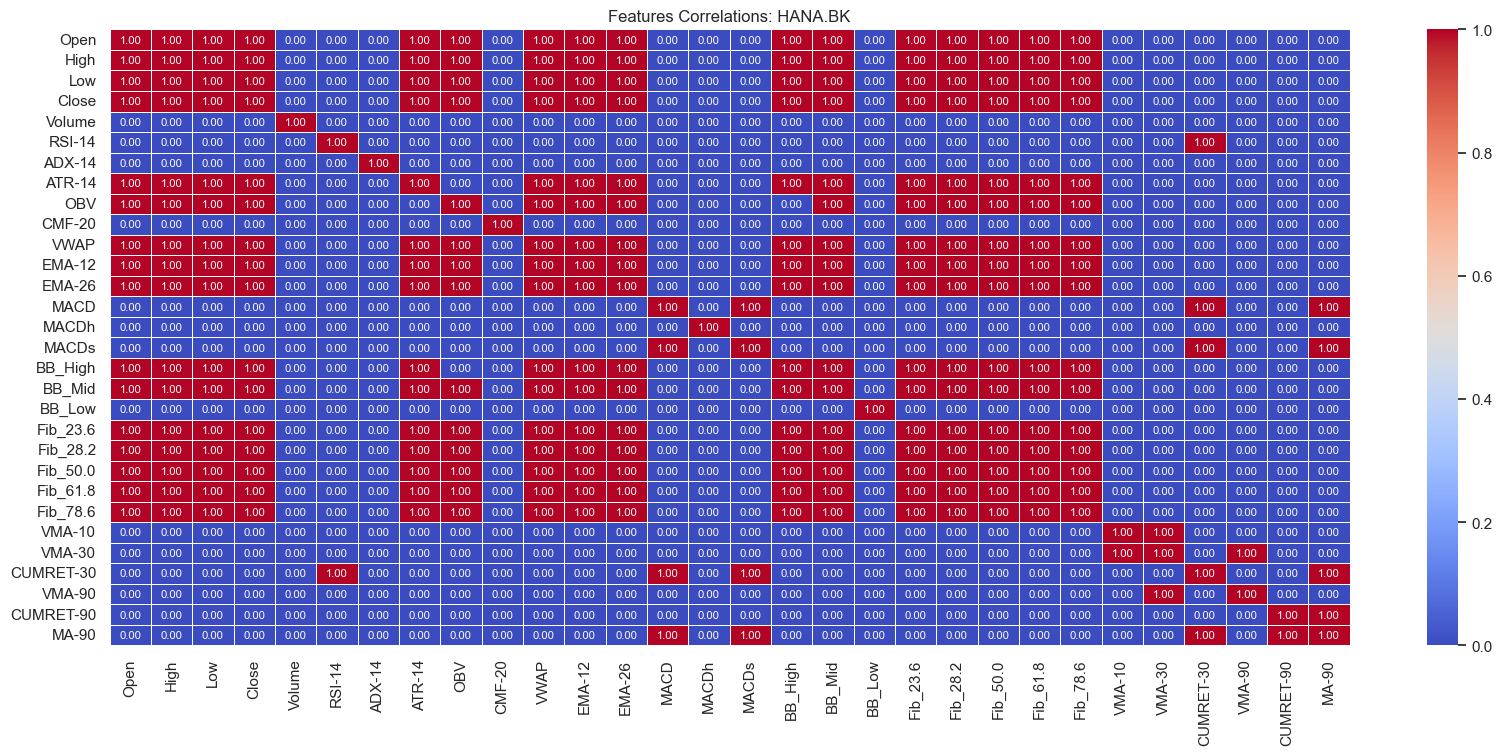

<Axes: >

Text(0.5, 1.0, 'Features Correlations: BAY.BK')

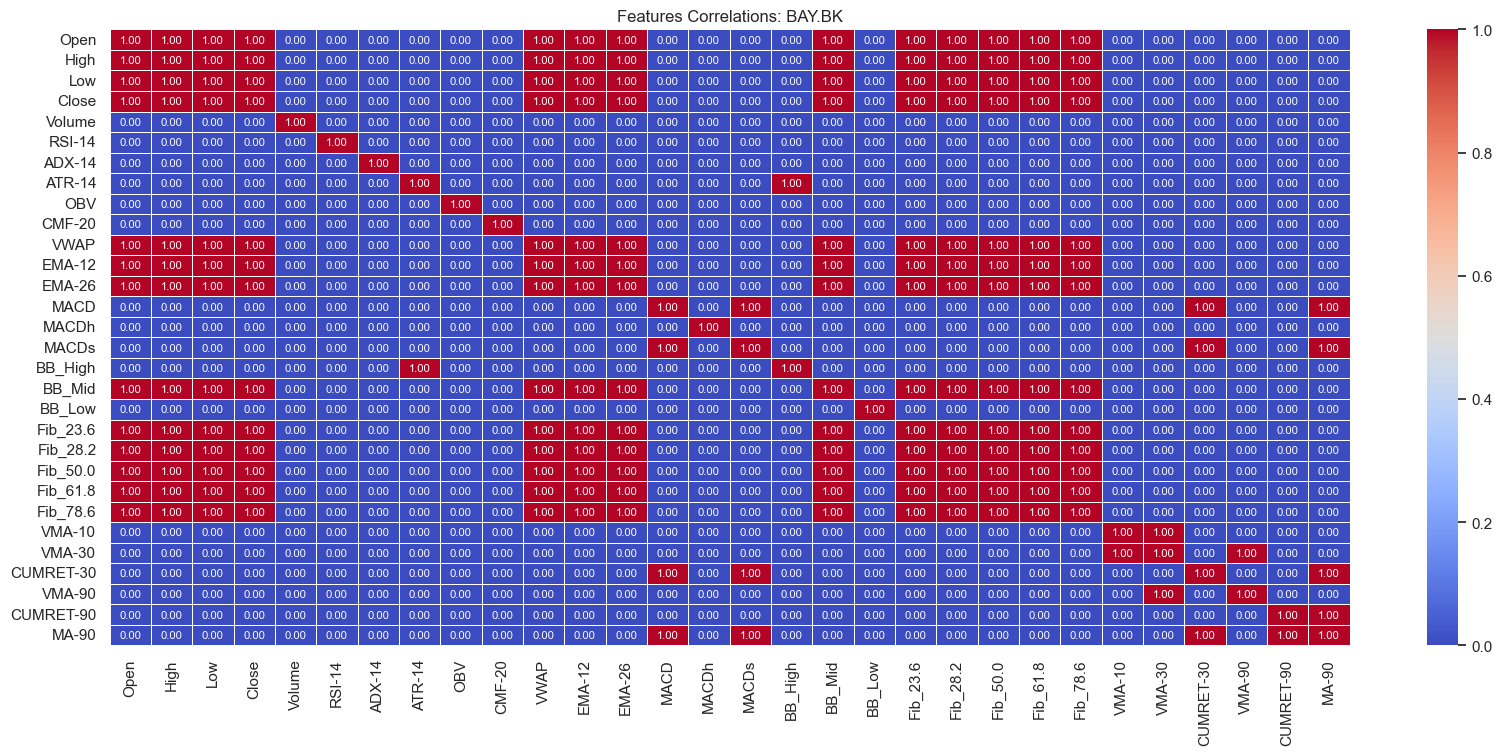

<Axes: >

Text(0.5, 1.0, 'Features Correlations: ADVANC.BK')

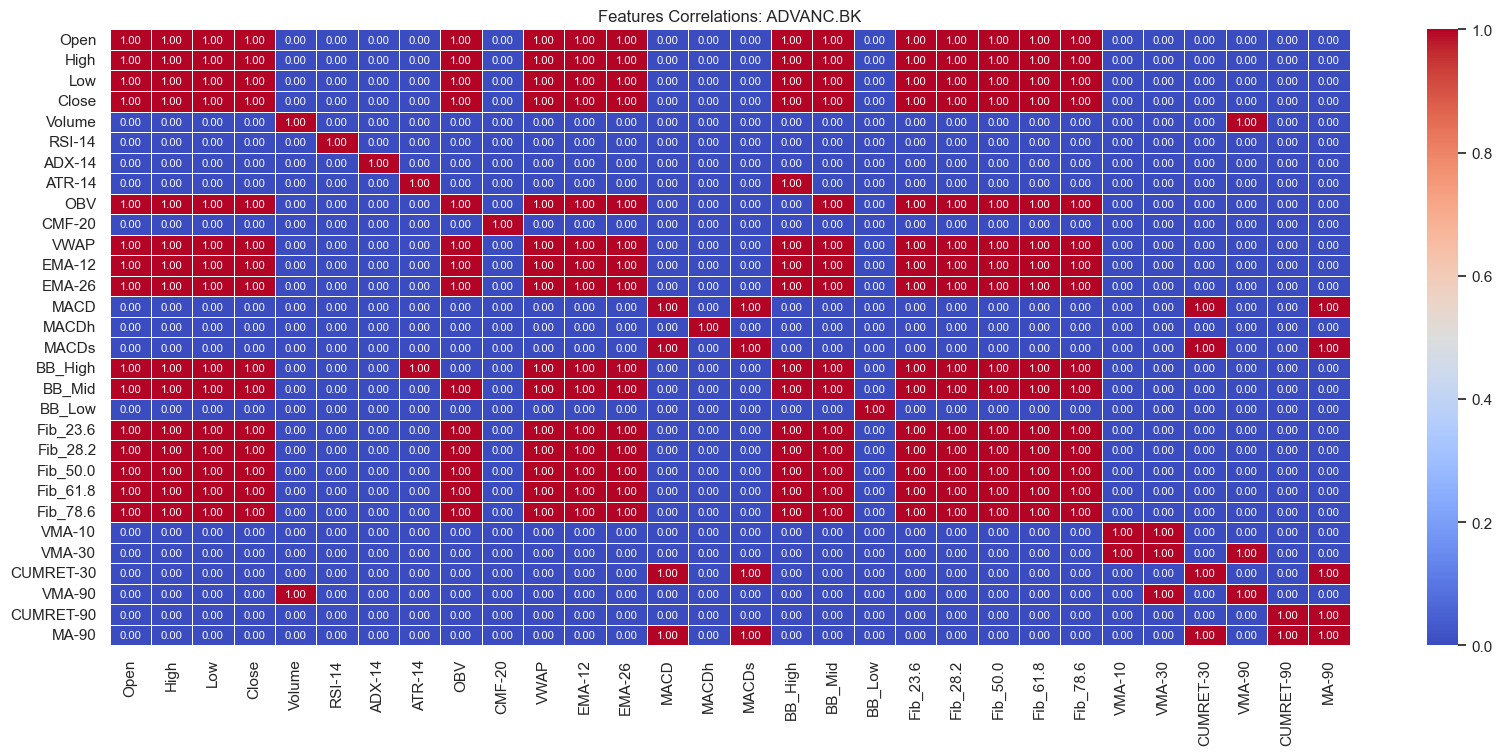

In [776]:
# Check features that are highly correlated
for asset in asset_list:
  sns.heatmap(X_selected[asset].corr()>0.8,
              annot=True,
              annot_kws={"size": 8},
              fmt=".2f",
              linewidth=.5,
              cmap="coolwarm",
              cbar=True)
  plt.title('Features Correlations: '+ asset)
  plt.show()

In [777]:
# Find the features that are high correlated to other features
def correlated_features(X, threshold=0.8):
    col_corr = set()
    corr_matrix = X.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                # Only add the feature to drop if it's not the 'Close' column
                if colname != "Close":
                    col_corr.add(colname)
    return col_corr

for asset in asset_list:
  print(f'Asset Name: {asset}')
  drop_features = correlated_features(X_selected[asset])
  print("Dropped features: ", drop_features)

  # Drop one of the features in each pair of highly correlated features
  X_selected[asset] = X_selected[asset].drop(drop_features, axis=1)

  X_selected[asset].describe()

Asset Name: HANA.BK
Dropped features:  {'EMA-26', 'Fib_61.8', 'High', 'EMA-12', 'Fib_78.6', 'ATR-14', 'Fib_23.6', 'MA-90', 'CUMRET-30', 'VWAP', 'BB_High', 'Fib_50.0', 'MACDs', 'VMA-90', 'BB_Mid', 'Low', 'VMA-30', 'OBV', 'Fib_28.2'}


Open        Close        Volume       RSI-14       ADX-14  \
count  3558.000000  3558.000000  3.558000e+03  3558.000000  3558.000000   
mean     28.970945    28.938023  5.097042e+06    50.950308    26.552934   
std      15.039927    14.999555  7.120740e+06    12.449720     9.652420   
min       8.121413     8.121414  0.000000e+00    16.389380    10.052156   
25%      16.956678    16.799999  8.144500e+05    42.113825    19.281564   
50%      26.080572    26.027705  2.355400e+06    51.081626    24.539361   
75%      37.395522    37.293266  6.754175e+06    60.116108    31.876920   
max      85.832110    85.832130  8.453130e+07    87.871919    60.348202   

            CMF-20         MACD        MACDh       BB_Low       VMA-10  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000   
mean     -0.043264     0.008584    -0.000852     4.740327     1.020392   
std       0.207516     1.104028     0.295699    15.549172     0.673510   
min      -0.673543    -6.264508    -1.189651   -81.272487     0.000000   
25%      -0.189651    -0.402987    -0.114840     0.762106     0.576224   
50%      -0.045703     0.052863    -0.001957     7.783997     0.864908   
75%       0.096897     0.503691     0.115711    12.454934     1.300696   
max       0.746772     3.946598     1.442765    60.645800     6.176328   

         CUMRET-90  
count  3558.000000  
mean      0.013076  
std       0.236423  
min      -0.615895  
25%      -0.152499  
50%       0.007006  
75%       0.174189  
max       0.849226

Asset Name: BAY.BK
Dropped features:  {'EMA-26', 'BB_High', 'Fib_61.8', 'Fib_50.0', 'VWAP', 'Fib_23.6', 'High', 'MA-90', 'MACDs', 'VMA-90', 'Fib_28.2', 'CUMRET-30', 'EMA-12', 'BB_Mid', 'Fib_78.6', 'Low', 'VMA-30'}


Open        Close        Volume       RSI-14       ADX-14  \
count  3558.000000  3558.000000  3.558000e+03  3558.000000  3558.000000   
mean     27.910286    27.876440  4.518624e+06    49.466609    25.828714   
std       6.232910     6.221298  9.883549e+06    12.320140     9.869387   
min      13.250764    13.474092  0.000000e+00    10.599568     9.173990   
25%      24.436548    24.350266  2.363000e+05    41.333319    18.342858   
50%      28.623676    28.593065  5.624000e+05    49.443237    23.876320   
75%      31.846014    31.765299  3.244325e+06    57.388642    31.196212   
max      75.566706    71.987206  1.328540e+08    89.223920    60.565717   

            ATR-14           OBV       CMF-20         MACD        MACDh  \
count  3558.000000  3.558000e+03  3558.000000  3558.000000  3558.000000   
mean      0.673137  8.935353e+08    -0.048786     0.016270    -0.000280   
std       0.406483  2.368894e+08     0.261470     0.686816     0.206040   
min       0.140695  2.213431e+08    -0.787887    -4.021804    -1.639977   
25%       0.472658  8.798767e+08    -0.227712    -0.274478    -0.074058   
50%       0.606613  9.833476e+08    -0.045764    -0.016160    -0.004178   
75%       0.766858  1.036499e+09     0.133355     0.298103     0.074018   
max       5.417525  1.109047e+09     0.804328     6.384919     2.621448   

            BB_Low       VMA-10    CUMRET-90  
count  3558.000000  3558.000000  3558.000000  
mean     12.814726     1.015331     0.011716  
std      15.203450     0.847172     0.177401  
min    -162.820381     0.000000    -0.625954  
25%       8.055743     0.486690    -0.083288  
50%      15.739068     0.801617    -0.004688  
75%      21.845461     1.257317     0.098518  
max      30.790140     8.154649     0.839352

Asset Name: ADVANC.BK
Dropped features:  {'EMA-26', 'OBV', 'BB_High', 'Fib_61.8', 'Fib_50.0', 'VWAP', 'Fib_23.6', 'High', 'MA-90', 'MACDs', 'VMA-90', 'Fib_28.2', 'CUMRET-30', 'EMA-12', 'BB_Mid', 'Fib_78.6', 'Low', 'VMA-30'}


Open        Close        Volume       RSI-14       ADX-14  \
count  3558.000000  3558.000000  3.558000e+03  3558.000000  3558.000000   
mean    148.987254   148.956627  6.561230e+06    52.855734    24.550131   
std      47.699888    47.694353  5.130121e+06    11.336515     9.924322   
min      39.423854    40.186893  0.000000e+00    19.626696     6.323928   
25%     124.535815   124.267830  3.771600e+06    44.940193    17.099876   
50%     149.744654   149.720345  5.408700e+06    52.962725    22.619890   
75%     172.730541   172.679398  7.785975e+06    60.520647    30.235132   
max     299.065421   298.084869  9.475180e+07    86.232417    64.273706   

            ATR-14       CMF-20         MACD        MACDh       BB_Low  \
count  3558.000000  3558.000000  3558.000000  3558.000000  3558.000000   
mean      2.965302    -0.018174     0.454359    -0.001763    84.066609   
std       1.295431     0.189733     2.257571     0.661617    50.314042   
min       0.508364    -0.592105   -12.599863    -3.268736  -244.012419   
25%       2.116752    -0.141350    -0.709981    -0.357489    51.878731   
50%       2.732796    -0.004822     0.548034     0.000361    87.804560   
75%       3.507285     0.102037     1.693273     0.374467   117.284447   
max       8.418705     0.563943     8.919193     2.771322   220.074432   

            VMA-10    CUMRET-90  
count  3558.000000  3558.000000  
mean      1.010432     0.049941  
std       0.517247     0.148955  
min       0.000000    -0.457194  
25%       0.668384    -0.043640  
50%       0.904789     0.028219  
75%       1.246866     0.151441  
max       4.588981     0.502399

## Modeling

In [865]:
# Train-test split
test_ratio = 0.2
N = len(X_selected[asset_list[0]])
N_test = int(test_ratio * N)
N_train = N - N_test

X_train, y_train = {}, {}
X_test, y_test = {}, {}
for asset in asset_list:
  X_train[asset], y_train[asset] = X_selected[asset].iloc[:N_train], y[asset].iloc[:N_train]
  X_test[asset], y_test[asset] = X_selected[asset].iloc[N_train:], y[asset].iloc[N_train:]

  X_train[asset].head()
  y_train[asset].head()

Open      Close     Volume     RSI-14     ADX-14    CMF-20  \
Date                                                                          
2010-09-02  12.993863  12.743981  3466000.0  40.221670  23.984610 -0.416248   
2010-09-03  12.868922  12.743981  7136800.0  40.221670  23.750495 -0.456245   
2010-09-06  12.868922  12.444122  2913200.0  35.319672  24.031714 -0.492194   
2010-09-07  12.494094  12.494094  1901100.0  36.704128  24.428965 -0.499022   
2010-09-08  12.494094  12.494094  4199600.0  36.704128  24.797694 -0.534679   

                MACD     MACDh    BB_Low    VMA-10  CUMRET-90  
Date                                                           
2010-09-02 -0.115318 -0.053392  8.524719  1.678133   0.109391  
2010-09-03 -0.133723 -0.057437  8.147801  2.735276   0.124417  
2010-09-06 -0.170538 -0.075402  7.393171  1.073567   0.073833  
2010-09-07 -0.193453 -0.078654  6.854001  0.722662   0.059706  
2010-09-08 -0.209201 -0.075522  7.084295  1.464515   0.050688

Date
2010-09-02    1
2010-09-03    0
2010-09-06    1
2010-09-07    1
2010-09-08    1
Name: Label, dtype: int64

Open      Close      Volume     RSI-14     ADX-14    ATR-14  \
Date                                                                           
2010-09-02  16.060021  15.988324  51961800.0  73.732201  22.006292  0.340153   
2010-09-03  16.131716  15.701536  39855100.0  65.708997  23.352698  0.356846   
2010-09-06  15.844934  15.558148  36825500.0  62.072163  24.602357  0.356963   
2010-09-07  15.717495  15.645064  19825300.0  63.394720  25.801845  0.358370   
2010-09-08  15.500202  15.282910  18748600.0  54.817373  25.224494  0.363819   

                    OBV    CMF-20      MACD     MACDh    BB_Low    VMA-10  \
Date                                                                        
2010-09-02  374386800.0  0.161206  0.277971  0.131311  5.963021  1.532935   
2010-09-03  334531700.0  0.119194  0.300159  0.122799  5.283731  1.090535   
2010-09-06  297706200.0  0.047330  0.302684  0.100259  4.906108  0.951913   
2010-09-07  317531500.0  0.040412  0.308147  0.084577  4.520770  0.498072   
2010-09-08  298782900.0  0.019486  0.280025  0.045164  4.481503  0.458115   

            CUMRET-90  
Date                   
2010-09-02   0.088420  
2010-09-03   0.084953  
2010-09-06   0.069638  
2010-09-07   0.103536  
2010-09-08   0.072207

Date
2010-09-02    0
2010-09-03    0
2010-09-06    1
2010-09-07    0
2010-09-08    1
Name: Label, dtype: int64

Open      Close      Volume     RSI-14     ADX-14    ATR-14  \
Date                                                                           
2010-09-02  44.851897  44.255463   4961500.0  59.585550  36.618974  0.809815   
2010-09-03  44.255457  44.374744   5187600.0  60.430152  36.518367  0.794555   
2010-09-06  44.851890  45.567612  12531000.0  67.699938  37.354789  0.857157   
2010-09-07  46.283339  46.044765  16178600.0  70.068762  38.425915  0.872631   
2010-09-08  45.686899  46.521908  19347500.0  72.259629  39.626051  0.895527   

              CMF-20      MACD     MACDh     BB_Low    VMA-10  CUMRET-90  
Date                                                                      
2010-09-02 -0.058559  0.750770 -0.083210  27.458116  0.843286   0.218611  
2010-09-03 -0.050311  0.725544 -0.086748  28.764828  0.923800   0.246087  
2010-09-06 -0.060528  0.792670 -0.015697  27.652381  1.961312   0.283343  
2010-09-07 -0.041407  0.874292  0.052740  26.540068  2.176041   0.305299  
2010-09-08  0.002240  0.966340  0.115830  24.593996  2.126438   0.314425

Date
2010-09-02    1
2010-09-03    2
2010-09-06    2
2010-09-07    2
2010-09-08    2
Name: Label, dtype: int64

## DecisionTreeClassifier

In [779]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

y_pred_model1 = {}
# Train DecisionTreeClassifier model
for asset in asset_list:
    model1 = DecisionTreeClassifier(criterion='log_loss',max_depth=16,min_samples_split=3)
    model1.fit(X_train[asset], y_train[asset])
    y_pred_model1[asset] = model1.predict(X_test[asset])
    # print(y_pred_model1)
    
    print()
    print(f'R Square : {round(r2_score(y_test[asset], y_pred_model1[asset]), 4)}')
    print(classification_report(y_test[asset], y_pred_model1[asset], zero_division=0))
    
    labels = ['Down', 'Stay', 'Up']
    cm = confusion_matrix(y_test[asset], y_pred_model1[asset])
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    df_cm.columns = pd.MultiIndex.from_product([['Predicted'], labels])
    df_cm.index = pd.MultiIndex.from_product([['Actual'], labels])
    print(df_cm)
    print("_"*70 + "\n")


DecisionTreeClassifier(criterion='log_loss', max_depth=16, min_samples_split=3)


R Square : -1.1814
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       256
           1       0.36      0.25      0.29       219
           2       0.33      0.42      0.37       236

    accuracy                           0.35       711
   macro avg       0.35      0.35      0.34       711
weighted avg       0.35      0.35      0.35       711

            Predicted          
                 Down Stay   Up
Actual Down        95   49  112
       Stay        73   54   92
       Up          91   46   99
______________________________________________________________________



DecisionTreeClassifier(criterion='log_loss', max_depth=16, min_samples_split=3)


R Square : -1.1291
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       222
           1       0.50      0.35      0.41       308
           2       0.29      0.35      0.32       181

    accuracy                           0.37       711
   macro avg       0.38      0.38      0.37       711
weighted avg       0.40      0.37      0.38       711

            Predicted         
                 Down Stay  Up
Actual Down        93   68  61
       Stay       101  109  98
       Up          75   42  64
______________________________________________________________________



DecisionTreeClassifier(criterion='log_loss', max_depth=16, min_samples_split=3)


R Square : -1.1804
              precision    recall  f1-score   support

           0       0.32      0.44      0.37       197
           1       0.41      0.21      0.28       303
           2       0.32      0.42      0.36       211

    accuracy                           0.34       711
   macro avg       0.35      0.36      0.34       711
weighted avg       0.35      0.34      0.33       711

            Predicted          
                 Down Stay   Up
Actual Down        86   38   73
       Stay       121   65  117
       Up          66   57   88
______________________________________________________________________



## GradientBoostingClassifier

In [780]:
from sklearn.ensemble import GradientBoostingClassifier

y_pred_model2 = {}

for asset in asset_list:
    model2 = GradientBoostingClassifier(max_depth=16, min_samples_split=3, random_state=42)
    model2.fit(X_train[asset], y_train[asset])
    y_pred_model2[asset] = model2.predict(X_test[asset])
    # print(y_pred_model2)
    
    print()
    print(f'R Square : {round(r2_score(y_test[asset], y_pred_model2[asset]), 4)}')
    print(classification_report(y_test[asset], y_pred_model2[asset], zero_division=0))
    
    labels = ['Down', 'Stay', 'Up']
    cm = confusion_matrix(y_test[asset], y_pred_model2[asset])
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    df_cm.columns = pd.MultiIndex.from_product([['Predicted'], labels])
    df_cm.index = pd.MultiIndex.from_product([['Actual'], labels])
    print(df_cm)
    print("_"*70 + "\n")

GradientBoostingClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.2404
              precision    recall  f1-score   support

           0       0.37      0.49      0.42       256
           1       0.27      0.09      0.14       219
           2       0.34      0.43      0.38       236

    accuracy                           0.35       711
   macro avg       0.33      0.34      0.31       711
weighted avg       0.33      0.35      0.32       711

            Predicted          
                 Down Stay   Up
Actual Down       125   26  105
       Stay       110   20   89
       Up         107   28  101
______________________________________________________________________



GradientBoostingClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.3188
              precision    recall  f1-score   support

           0       0.37      0.46      0.41       222
           1       0.40      0.13      0.20       308
           2       0.27      0.49      0.35       181

    accuracy                           0.33       711
   macro avg       0.34      0.36      0.32       711
weighted avg       0.36      0.33      0.30       711

            Predicted          
                 Down Stay   Up
Actual Down       103   29   90
       Stay       119   41  148
       Up          60   33   88
______________________________________________________________________



GradientBoostingClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.3987
              precision    recall  f1-score   support

           0       0.27      0.48      0.35       197
           1       0.35      0.16      0.22       303
           2       0.30      0.32      0.31       211

    accuracy                           0.30       711
   macro avg       0.31      0.32      0.29       711
weighted avg       0.31      0.30      0.28       711

            Predicted         
                 Down Stay  Up
Actual Down        95   37  65
       Stay       164   47  92
       Up          94   49  68
______________________________________________________________________



## RandomForestClassifier

In [781]:
from sklearn.ensemble import RandomForestClassifier

y_pred_model3 = {}

for asset in asset_list:
    model3 = RandomForestClassifier(max_depth=16, min_samples_split=3, random_state=42)
    model3.fit(X_train[asset], y_train[asset])
    y_pred_model3[asset] = model3.predict(X_test[asset])
    # print(y_pred_model3)
    
    print()
    print(f'R Square : {round(r2_score(y_test[asset], y_pred_model3[asset]), 4)}')
    print(classification_report(y_test[asset], y_pred_model3[asset], zero_division=0))
    
    labels = ['Down', 'Stay', 'Up']
    cm = confusion_matrix(y_test[asset], y_pred_model3[asset])
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    df_cm.columns = pd.MultiIndex.from_product([['Predicted'], labels])
    df_cm.index = pd.MultiIndex.from_product([['Actual'], labels])
    print(df_cm)
    print("_"*70 + "\n")

RandomForestClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.2709
              precision    recall  f1-score   support

           0       0.36      0.56      0.44       256
           1       0.16      0.04      0.06       219
           2       0.34      0.39      0.36       236

    accuracy                           0.34       711
   macro avg       0.29      0.33      0.29       711
weighted avg       0.29      0.34      0.30       711

            Predicted         
                 Down Stay  Up
Actual Down       144   20  92
       Stay       130    8  81
       Up         124   21  91
______________________________________________________________________



RandomForestClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.4885
              precision    recall  f1-score   support

           0       0.34      0.56      0.42       222
           1       0.49      0.10      0.16       308
           2       0.27      0.42      0.33       181

    accuracy                           0.32       711
   macro avg       0.37      0.36      0.30       711
weighted avg       0.39      0.32      0.29       711

            Predicted          
                 Down Stay   Up
Actual Down       124   11   87
       Stay       157   30  121
       Up          85   20   76
______________________________________________________________________



RandomForestClassifier(max_depth=16, min_samples_split=3, random_state=42)


R Square : -1.1681
              precision    recall  f1-score   support

           0       0.28      0.56      0.38       197
           1       0.38      0.26      0.31       303
           2       0.32      0.18      0.23       211

    accuracy                           0.32       711
   macro avg       0.33      0.33      0.30       711
weighted avg       0.34      0.32      0.30       711

            Predicted         
                 Down Stay  Up
Actual Down       111   55  31
       Stay       178   78  47
       Up         102   72  37
______________________________________________________________________



## DecisionTreeClassifier Tunning

In [782]:
y_pred_model_OptimalDT = {}

for asset in asset_list:
    parameters = {
        'criterion': ['gini', 'entropy'], 
        'max_depth': np.arange(1, 11).tolist()[0::2],
        'min_samples_split': np.arange(2, 11).tolist()[0::2]
    }
    print(f"Tuning Decision Tree for {asset}...")
    model_tuner = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                               parameters, 
                               scoring='accuracy', 
                               n_jobs=-1)
    model_tuner.fit(X_train[asset], y_train[asset])
    
    best_params = model_tuner.best_params_
    print("Best Params:", best_params)
    
    model_OptimalDT = model_tuner.best_estimator_
    y_pred_model_OptimalDT[asset] = model_OptimalDT.predict(X_test[asset])
    
    print('Classification Report\n')
    print(classification_report(y_test[asset], y_pred_model_OptimalDT[asset], zero_division=0))
    print("_"*70 + "\n")

Tuning Decision Tree for HANA.BK...


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='accuracy')

Best Params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
Classification Report

              precision    recall  f1-score   support

           0       0.36      1.00      0.53       256
           1       0.00      0.00      0.00       219
           2       0.00      0.00      0.00       236

    accuracy                           0.36       711
   macro avg       0.12      0.33      0.18       711
weighted avg       0.13      0.36      0.19       711

______________________________________________________________________

Tuning Decision Tree for BAY.BK...


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='accuracy')

Best Params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
Classification Report

              precision    recall  f1-score   support

           0       0.37      0.64      0.46       222
           1       0.58      0.61      0.60       308
           2       0.00      0.00      0.00       181

    accuracy                           0.46       711
   macro avg       0.32      0.42      0.35       711
weighted avg       0.37      0.46      0.40       711

______________________________________________________________________

Tuning Decision Tree for ADVANC.BK...


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='accuracy')

Best Params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       197
           1       0.42      0.88      0.57       303
           2       0.33      0.13      0.19       211

    accuracy                           0.41       711
   macro avg       0.25      0.34      0.25       711
weighted avg       0.28      0.41      0.30       711

______________________________________________________________________



## RandomForestClassifier Tunning

In [783]:
y_pred_model_OptimalRF = {}

for asset in asset_list:
    parameters = {
        'max_depth': np.arange(1, 21).tolist()[::2],        # e.g., [1, 3, 5, ..., 19]
        'min_samples_split': np.arange(2, 11).tolist()[::2],  # e.g., [2, 4, 6, 8, 10]
        'n_estimators': [50, 100, 150]                        # Number of trees in the forest
    }
    print(f"Tuning Random Forest for {asset}...")
    
    model_tuner = GridSearchCV(RandomForestClassifier(random_state=42),
                               parameters,
                               scoring='accuracy',
                               n_jobs=-1)
    
    model_tuner.fit(X_train[asset], y_train[asset])
    
    best_params = model_tuner.best_params_
    print("Best Params:", best_params)
    
    model_OptimalRF = model_tuner.best_estimator_
    y_pred_model_OptimalRF[asset] = model_OptimalRF.predict(X_test[asset])
    
    print('Classification Report\n')
    print(classification_report(y_test[asset], y_pred_model_OptimalRF[asset], zero_division=0))
    print("_"*70 + "\n")

Tuning Random Forest for HANA.BK...


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

Best Params: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report

              precision    recall  f1-score   support

           0       0.37      0.66      0.48       256
           1       0.32      0.29      0.30       219
           2       0.48      0.12      0.19       236

    accuracy                           0.37       711
   macro avg       0.39      0.36      0.32       711
weighted avg       0.39      0.37      0.33       711

______________________________________________________________________

Tuning Random Forest for BAY.BK...


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

Best Params: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report

              precision    recall  f1-score   support

           0       0.31      0.98      0.48       222
           1       0.50      0.03      0.05       308
           2       0.20      0.01      0.01       181

    accuracy                           0.32       711
   macro avg       0.34      0.34      0.18       711
weighted avg       0.37      0.32      0.17       711

______________________________________________________________________

Tuning Random Forest for ADVANC.BK...


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

Best Params: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report

              precision    recall  f1-score   support

           0       0.25      0.26      0.26       197
           1       0.44      0.67      0.53       303
           2       0.38      0.09      0.14       211

    accuracy                           0.38       711
   macro avg       0.36      0.34      0.31       711
weighted avg       0.37      0.38      0.34       711

______________________________________________________________________



model1 = DecisionTreeClassifier <br>
model2 = GradientBoostingClassifier <br>
model3 = RandomForestClassifier <br>
model_OptimalDT = Tuned DecisionTreeClassifier <br>
model_OptimalRF = Tuned RandomForestClassifier <br>

In [784]:
accuracy_scores = {}

for asset in asset_list:
    accuracy_scores[asset] = {
    
    # Replace 'y_test[asset]' with your actual y_test dictionary
    # For each model, calculate accuracy
    'DecisionTreeClassifier' : accuracy_score(y_test[asset], y_pred_model1[asset]),
    'GradientBoostingClassifier' : accuracy_score(y_test[asset], y_pred_model2[asset]),
    'RandomForestClassifier' : accuracy_score(y_test[asset], y_pred_model3[asset]),
    'Tuned DecisionTreeClassifier' : accuracy_score(y_test[asset], y_pred_model_OptimalDT[asset]),
    'Tuned RandomForestClassifier' : accuracy_score(y_test[asset], y_pred_model_OptimalRF[asset])
    }
# Convert nested dict to a DataFrame
all_accuracy_scores = [accuracy_scores[a] for a in asset_list]
accuracy_df = pd.DataFrame(all_accuracy_scores, index=asset_list)

print("Accuracy Scores Table:\n", accuracy_df.T.to_string())

# Transpose so rows = model, columns = asset
accuracy_df = accuracy_df.T

# Find best model per asset
highest_accuracy_models = accuracy_df.idxmax(axis=0)
highest_accuracy_scores = accuracy_df.max(axis=0)

print("\nHighest Accuracy Models:")
for asset in asset_list:
    print(f"{asset}: {highest_accuracy_models[asset]} (Accuracy: {highest_accuracy_scores[asset]:.4f})")

Accuracy Scores Table:
                                HANA.BK    BAY.BK  ADVANC.BK
DecisionTreeClassifier        0.348805  0.374121   0.336146
GradientBoostingClassifier    0.345992  0.326301   0.295359
RandomForestClassifier        0.341772  0.323488   0.317862
Tuned DecisionTreeClassifier  0.360056  0.464135   0.413502
Tuned RandomForestClassifier  0.365682  0.317862   0.382560

Highest Accuracy Models:
HANA.BK: Tuned RandomForestClassifier (Accuracy: 0.3657)
BAY.BK: Tuned DecisionTreeClassifier (Accuracy: 0.4641)
ADVANC.BK: Tuned DecisionTreeClassifier (Accuracy: 0.4135)


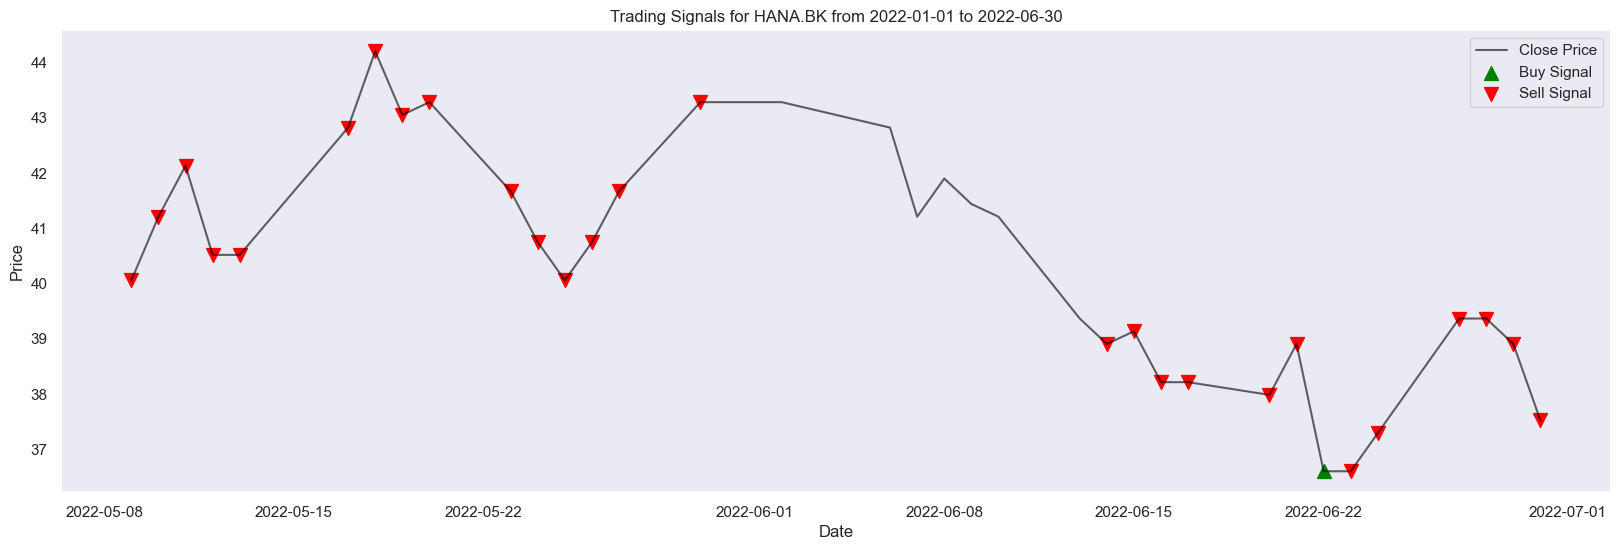

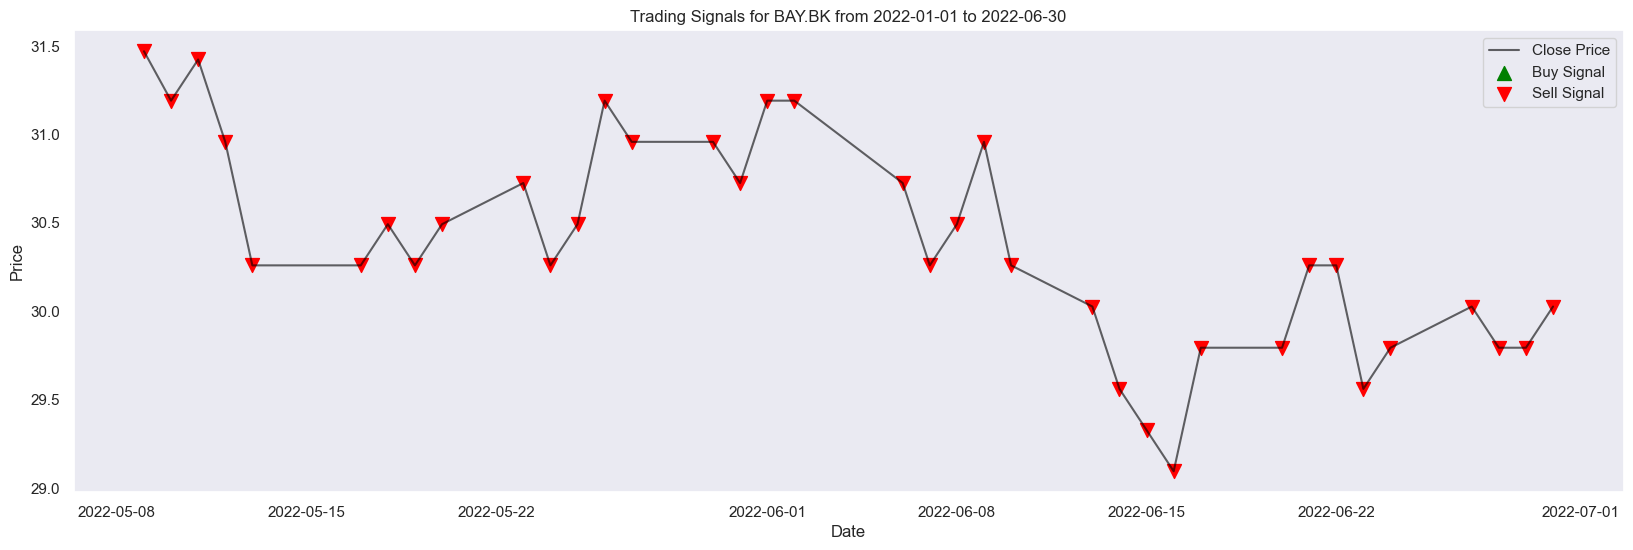

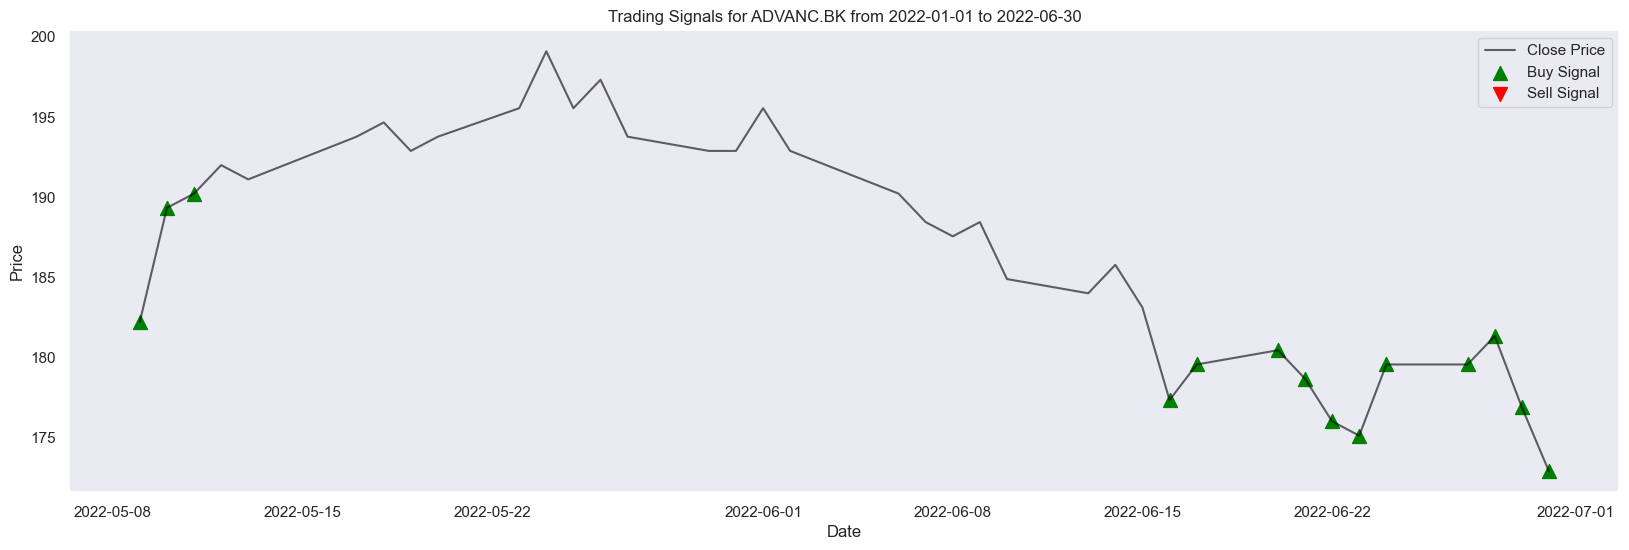

In [ ]:
def generate_trading_signals(period_start, period_end):

    selected_models = {asset_list[0]: model_OptimalRF,
                      asset_list[1]: model_OptimalDT,
                      asset_list[2]: model_OptimalDT }
    # Create a dictionary to store predictions
    y_pred = {}
    
    # Loop over each asset in your asset_list
    for asset in asset_list:
        # Slice X_test for the input period
        X_test_period = X_test[asset].loc[period_start:period_end]
        
        # Get common columns between training and the sliced test set
        common_cols = X_train[asset].columns.intersection(X_test_period.columns)
        X_train_asset_common = X_train[asset][common_cols]
        X_test_asset_common = X_test_period[common_cols]
        
        # Select model for this asset (from your selected_models dictionary)
        selected_model = selected_models[asset]
        
        # Fit the model on the training data (using the common columns)
        selected_model.fit(X_train_asset_common, y_train[asset])
        
        # Get predictions for the sliced test set and create a DataFrame with the test set's index
        y_pred[asset] = pd.DataFrame(selected_model.predict(X_test_asset_common),
                                     index=X_test_period.index,
                                     columns=['Label'])
        
        # Plot the closing price
        plt.figure(figsize=(20, 6))
        plt.plot(X_test_period.index, X_test_period['Close'], label='Close Price', color='black', alpha=0.6)
        
        # Identify trading signals based on predicted Label:
        # Assuming your signal classes: 2 = Buy, 0 = Sell (and 1 = Stay)
        buy_signals = X_test_period.index[y_pred[asset]['Label'] == 2]
        sell_signals = X_test_period.index[y_pred[asset]['Label'] == 0]
        
        # Plot buy and sell signals
        plt.scatter(buy_signals, X_test_period['Close'][buy_signals], marker='^', color='green', label='Buy Signal', s=100)
        plt.scatter(sell_signals, X_test_period['Close'][sell_signals], marker='v', color='red', label='Sell Signal', s=100)
        
        plt.title(f'Trading Signals for {asset} from {period_start} to {period_end}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.show()
        
    return y_pred

y_pred = generate_trading_signals('2022-01-01', '2022-06-30')
custom_period = slice('2022-01-01', '2022-06-30')
X_custom = {asset: X_selected[asset].loc[custom_period] for asset in asset_list}


## Trade simulation by AJ'SUN

In [855]:
# Assume that the (annual) risk-free rate is used as the interest rates for both savings and borrowing cash
risk_free_rate = 2/100

# Transaction fee rate for buying/selling stock
transaction_fee_rate = 0.3/100

# Asset borrowing fee rate (annual)
borrowing_fee_rate = 5.5/100

# Initial cash
initial_cash = 100.0
initial_cash*=34.2

In [856]:
def simulate_strategy(X, predictions):
    df1 = pd.DataFrame()
    for asset in asset_list:
      df1[('Close',asset)] = X[asset]['Close']
      df1[('Signal',asset)] = predictions[asset]['Label']
    df1['days_diff'] = df1.index.to_series().diff().dt.days
    df1.at[df1.index[0], 'days_diff'] = 1




    cash_list, portfolio_value_list = [], []
    cash = initial_cash
    asset_position = {asset: 0 for asset in asset_list}
    asset_position_list = {asset: [] for asset in asset_list}

    for index, row in df1.iterrows():
        # Apply interest on cash
        days_diff = row['days_diff']
        cash *= (1 + risk_free_rate/365)**days_diff

        for asset in asset_list:
          signal = row[('Signal',asset)]
          close = row[('Close',asset)]

          # Deduct the borrowing fee in case stock is in short position
          if asset_position[asset]<0:
            cash -= borrowing_fee_rate*(days_diff/365)*(abs(asset_position[asset])*close)

          # Execute our trading strategy
          if signal == 2:
            # Up: Buy one unit of asset
            asset_change = +1
          elif signal == 0:
            # Down: Sell one unit of asset
            asset_change = -1
          else:
            # Stay: Do nothing
            asset_change = 0

          # Update the asset position
          asset_position[asset] += asset_change
          asset_position_list[asset].append(asset_position[asset])
          transaction_fee = transaction_fee_rate*abs(asset_change*close)
          cash -= (asset_change*close + transaction_fee)

        # Update portfolio value
        asset_value = sum([asset_position[asset]*row[('Close',asset)] for asset in asset_list])
        portfolio_value = cash + asset_value
        portfolio_value_list.append(portfolio_value)
        cash_list.append(cash)

    # Add computed columns to DataFrame
    df1['Cash'] = cash_list
    df1['Portfolio Value'] = portfolio_value_list
    df1['Strategy Returns'] = df1['Portfolio Value'].pct_change(1)
    for asset in asset_list:
      df1[('Asset',asset)] = asset_position_list[asset]

    return df1

# Simulate our strategy
# df1 = simulate_strategy(X_test , predictions_df)   # for ensemble model
df1 = simulate_strategy(X_custom, y_pred)          # for individual model

Text(0.5, 0, 'Time')

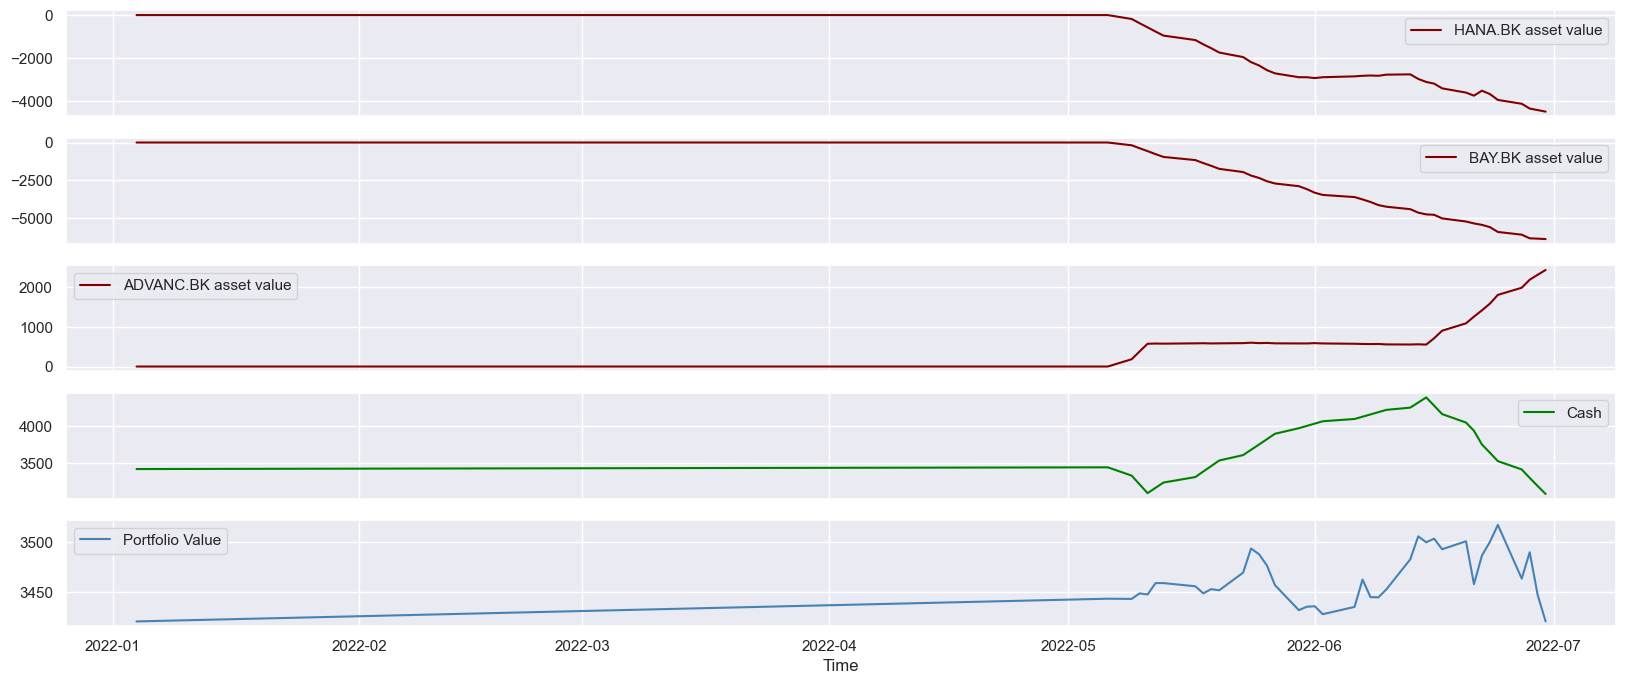

In [857]:
# Plot the values of stock and cash in our portfolio
fig, axes = plt.subplots(len(asset_list)+2, 1, figsize=(20, 8), sharex=True)

for i in range(len(asset_list)):
  axes[i].plot(df1[('Asset',asset_list[i])]*df1[('Close',asset)], label=asset_list[i]+' asset value', color='maroon')
  axes[i].legend()

axes[len(asset_list)].plot(df1['Cash'], label='Cash', color='green')
axes[len(asset_list)].legend()

axes[len(asset_list)+1].plot(df1['Portfolio Value'], label='Portfolio Value', color='steelblue')
axes[len(asset_list)+1].legend()

plt.xlabel('Time')
plt.show()

In [858]:
# Implement baseline strategy

# Determine the initial amount of each asset so that the values of all assets in the initial portfolio are equal
asset_amount = {asset: initial_cash/len(asset_list)/X_custom[asset]['Close'].iloc[0] for asset in asset_list}
print(asset_amount)

# Calculate the daily returns of the baseline strategy
df1['Baseline Value'] = np.sum([X_custom[asset]['Close']*asset_amount[asset] for asset in asset_list], axis=0)
df1['Baseline Returns'] = df1['Baseline Value'].pct_change(1)

{'HANA.BK': 14.458123984379796, 'BAY.BK': 34.95008887097722, 'ADVANC.BK': 5.726501760121707}


<Figure size 2000x600 with 0 Axes>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

Text(0.5, 0, 'Returns')

Text(0, 0.5, 'Density')

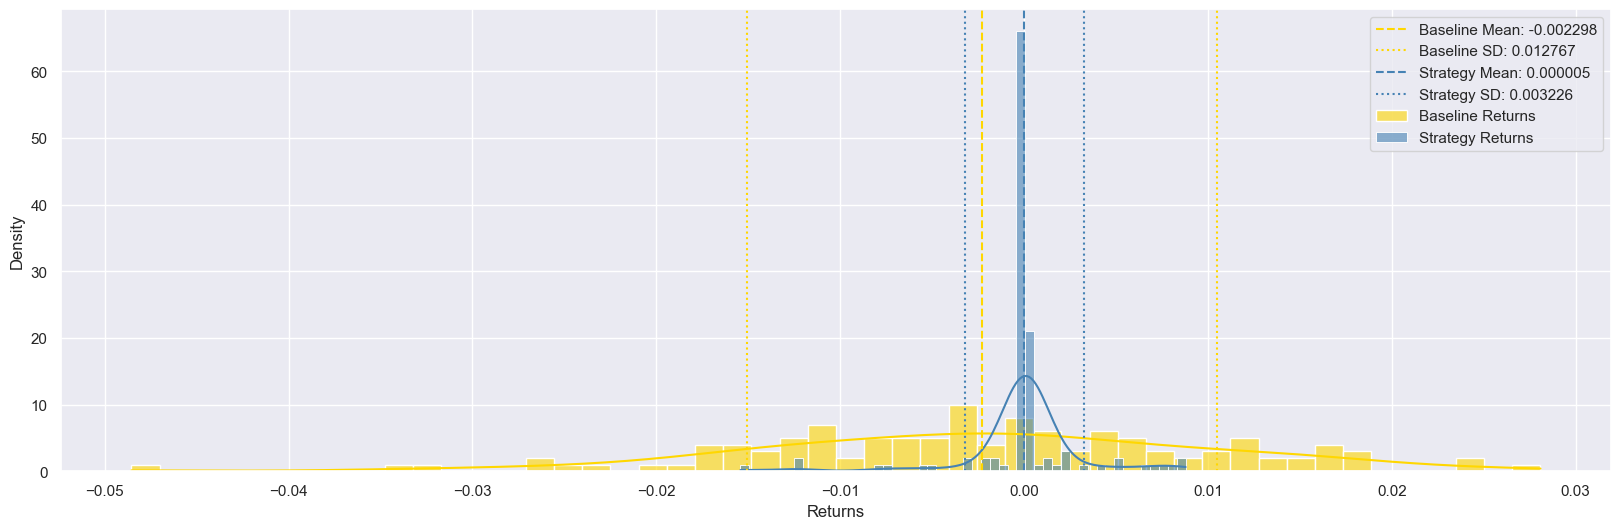

In [859]:
# Calculate the average and standard deviation
baseline_mean = df1['Baseline Returns'].mean()
baseline_std = df1['Baseline Returns'].std()

strategy_mean = df1['Strategy Returns'].mean()
strategy_std = df1['Strategy Returns'].std()

plt.figure(figsize=(20, 6))

# Plot histograms with KDE curves for Baseline Returns and Strategy Returns
sns.histplot(df1['Baseline Returns'], bins=50, kde=True, color='gold', label='Baseline Returns', alpha=0.6)
sns.histplot(df1['Strategy Returns'], bins=50, kde=True, color='steelblue', label='Strategy Returns', alpha=0.6)

# Add vertical lines for mean and standard deviation
plt.axvline(baseline_mean, color='gold', linestyle='--', label=f'Baseline Mean: {baseline_mean:.6f}')
plt.axvline(baseline_mean + baseline_std, color='gold', linestyle=':', label=f'Baseline SD: {baseline_std:.6f}')
plt.axvline(baseline_mean - baseline_std, color='gold', linestyle=':')
plt.axvline(strategy_mean, color='steelblue', linestyle='--', label=f'Strategy Mean: {strategy_mean:.6f}')
plt.axvline(strategy_mean + strategy_std, color='steelblue', linestyle=':', label=f'Strategy SD: {strategy_std:.6f}')
plt.axvline(strategy_mean - strategy_std, color='steelblue', linestyle=':')

# Adding labels and legend
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

<Figure size 2000x800 with 0 Axes>

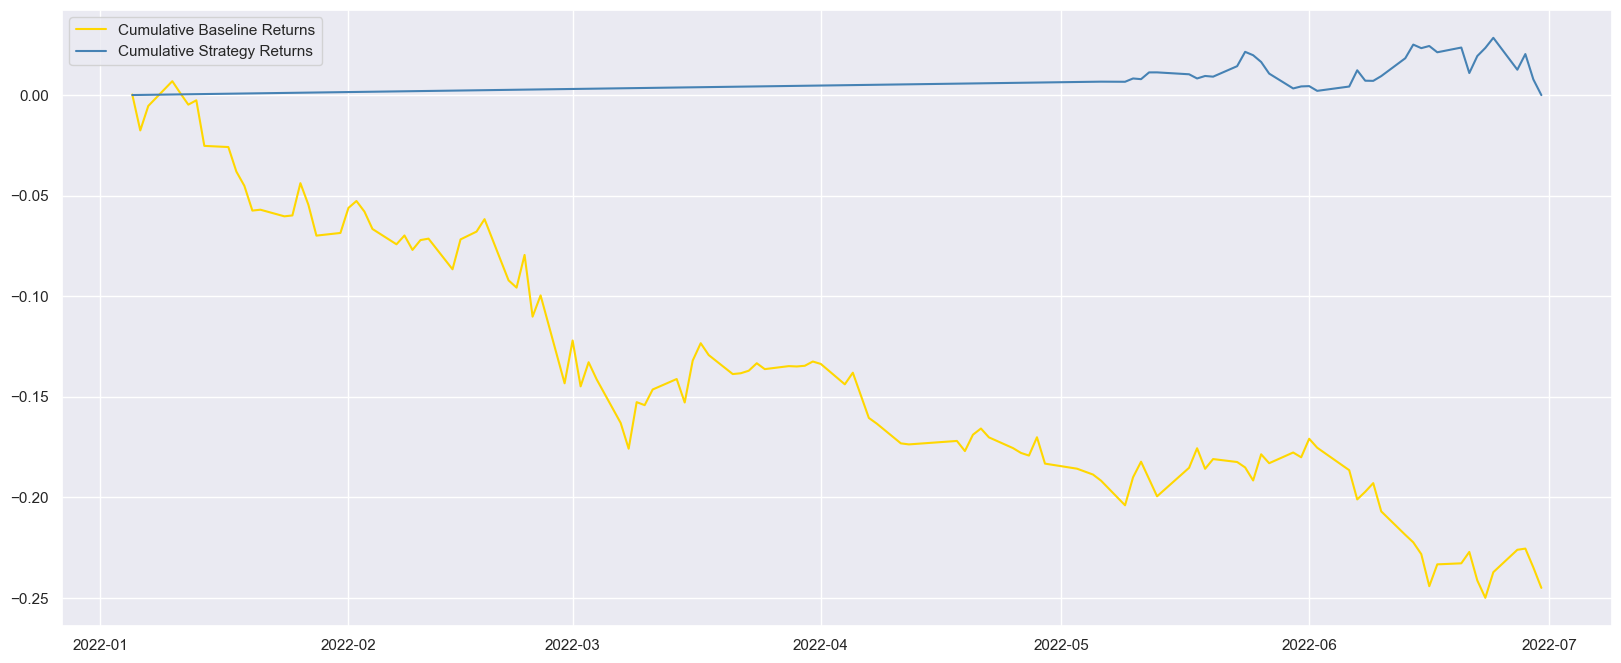

In [860]:
# Calculate cumulative log returns
df1['Cumulative Baseline Returns'] = (1 + df1['Baseline Returns']).cumprod()-1
df1['Cumulative Strategy Returns'] = (1 + df1['Strategy Returns']).cumprod()-1

# Plot cumulative returns
plt.figure(figsize=(20, 8))
plt.plot(df1['Cumulative Baseline Returns'], label='Cumulative Baseline Returns', color='gold')
plt.plot(df1['Cumulative Strategy Returns'], label='Cumulative Strategy Returns', color='steelblue')
plt.legend()
plt.show()

In [861]:
print("Final Portfolio Values")
baseline_final_value = initial_cash*(1+df1['Cumulative Baseline Returns'].iloc[-1])
strategy_final_value = initial_cash*(1+df1['Cumulative Strategy Returns'].iloc[-1])
print("Baseline: {:.2f} THB".format(baseline_final_value))
print("Our Strategy: {:.2f} THB".format(strategy_final_value))

print("Equivalent Annual Returns")
days_count = df1['days_diff'].iloc[-N_test+1:].sum()+1
baseline_equivalent_rate = (baseline_final_value/initial_cash)**(365/days_count)-1
strategy_equivalent_rate = (strategy_final_value/initial_cash)**(365/days_count)-1
print("Baseline: {:.2f}%".format(baseline_equivalent_rate*100))
print("Our Strategy: {:.2f}%".format(strategy_equivalent_rate*100))

Final Portfolio Values
Baseline: 2581.93 THB
Our Strategy: 3420.05 THB
Equivalent Annual Returns
Baseline: -43.63%
Our Strategy: 0.00%


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-06   2022-01-06
End Period                 2022-06-30   2022-06-30
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          -24.53%      -0.0%
CAGR﹪                     -33.32%      -0.01%

Sharpe                     -2.97        -0.36
Prob. Sharpe Ratio         1.26%        42.11%
Smart Sharpe               -2.58        -0.31
Sortino                    -3.57        -0.46
Smart Sortino              -3.1         -0.4
Sortino/√2                 -2.53        -0.32
Smart Sortino/√2           -2.19        -0.28
Omega                      0.9          0.9

Max Drawdown               -25.52%      -2.77%
Longest DD Days            171          20
Volatility (ann.)          20.35%       5.14%
R^2                        0.03         0.03
Information Ratio          0.17         0.17
Calmar             

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-06-27  2022-06-30  2022-06-30     4     -2.771206         -2.012306
2  2022-05-25  2022-06-02  2022-06-13    20     -1.899595         -1.782326
3  2022-06-15  2022-06-21  2022-06-23     9     -1.379574         -0.554975
4  2022-05-17  2022-05-18  2022-05-20     4     -0.299738         -0.210575
5  2022-05-11  2022-05-11  2022-05-11     1     -0.033834               NaN

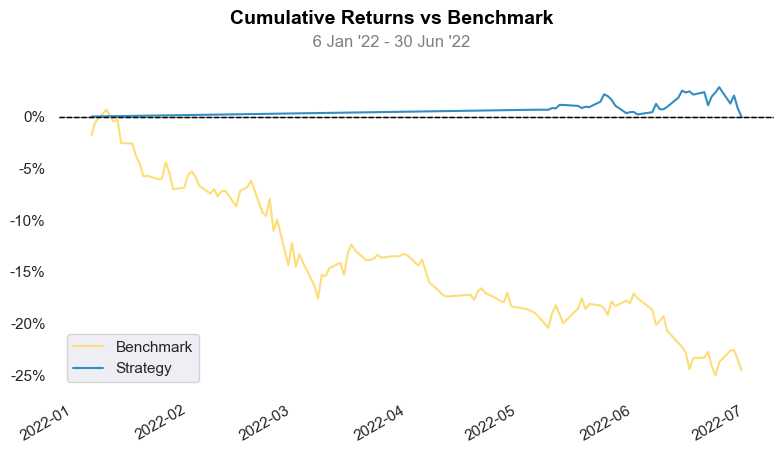

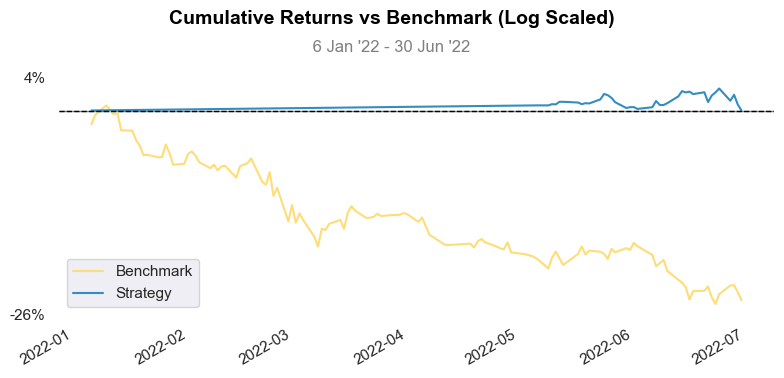

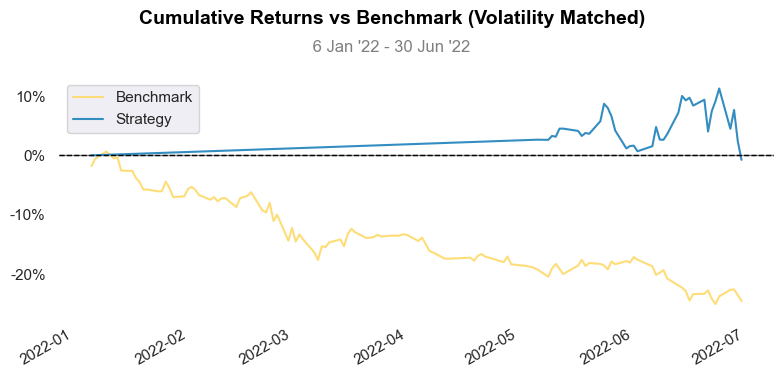

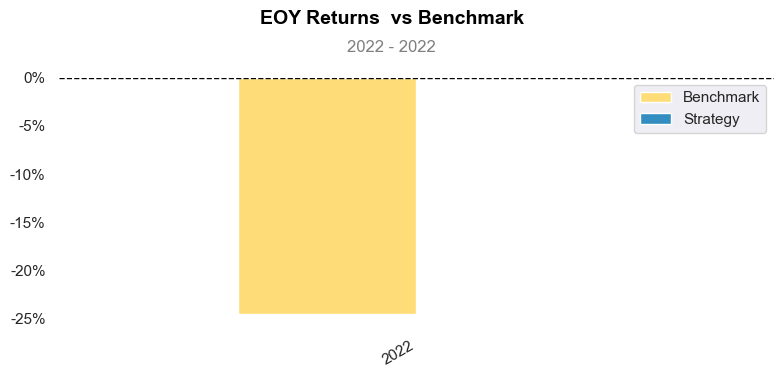

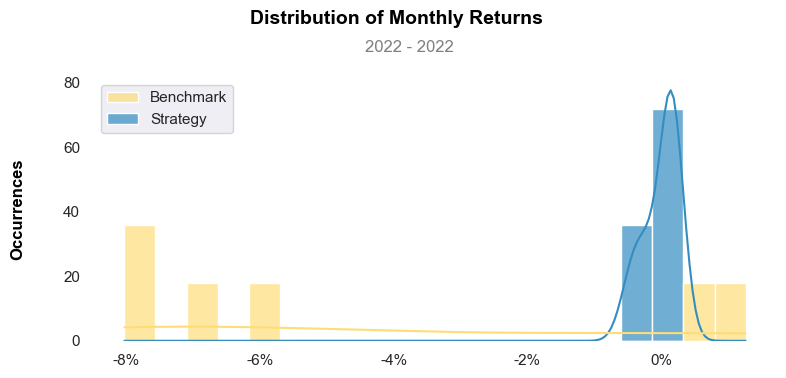

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/quantstats/_plotting/core.py:294: FutureWarning:

Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.



UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [862]:
# Use QuantStats to generate portfolio performance reports
# comparing ML-drive trading strategy against baseline strategy

# Full report
qs.reports.full(df1['Strategy Returns'], df1['Baseline Returns'], rf=risk_free_rate)

## Period 2

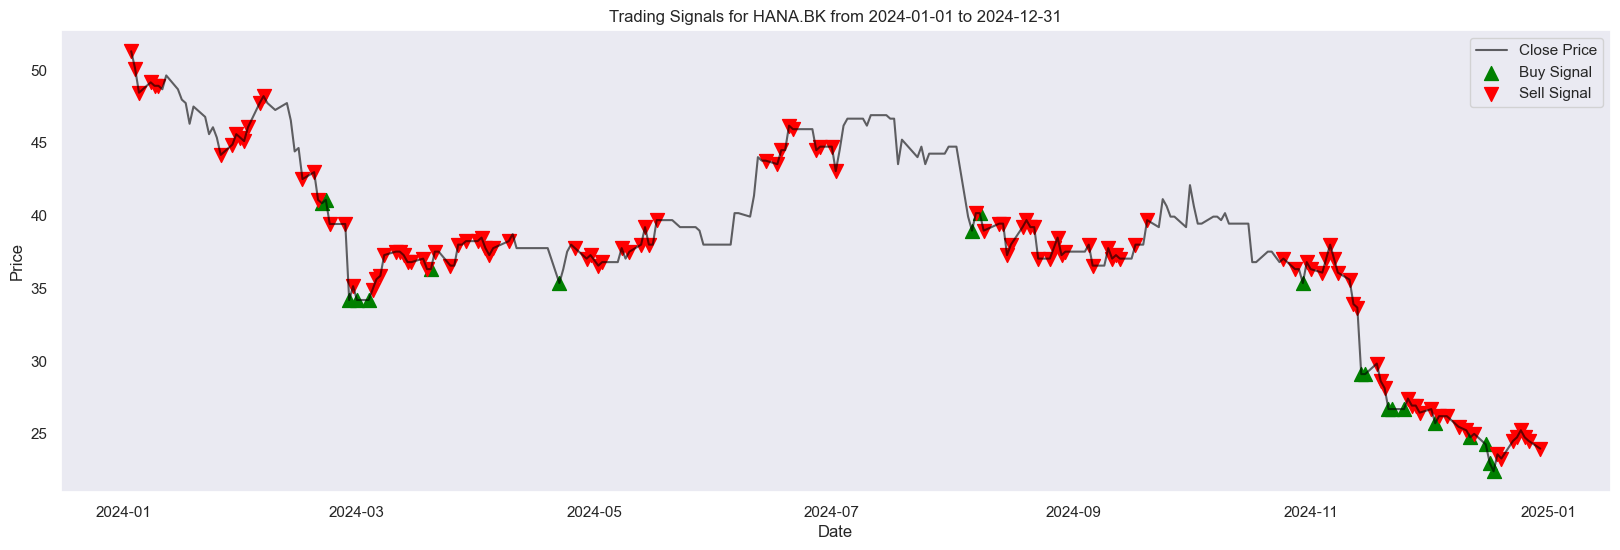

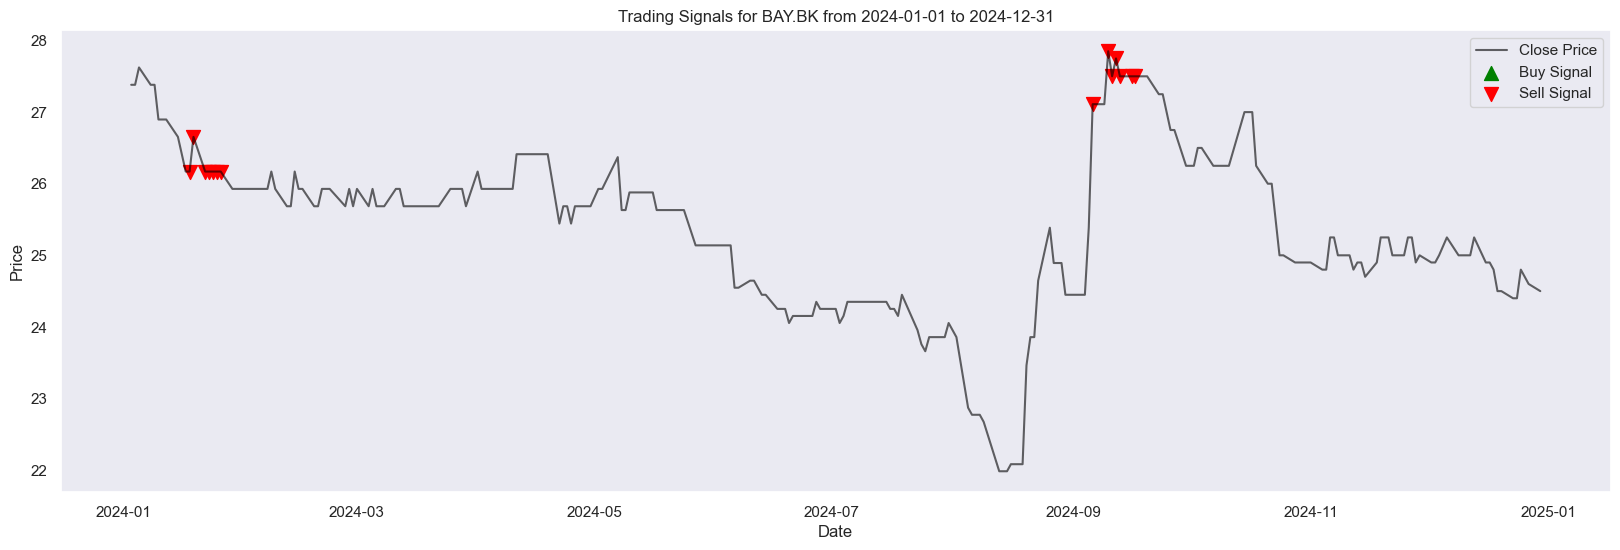

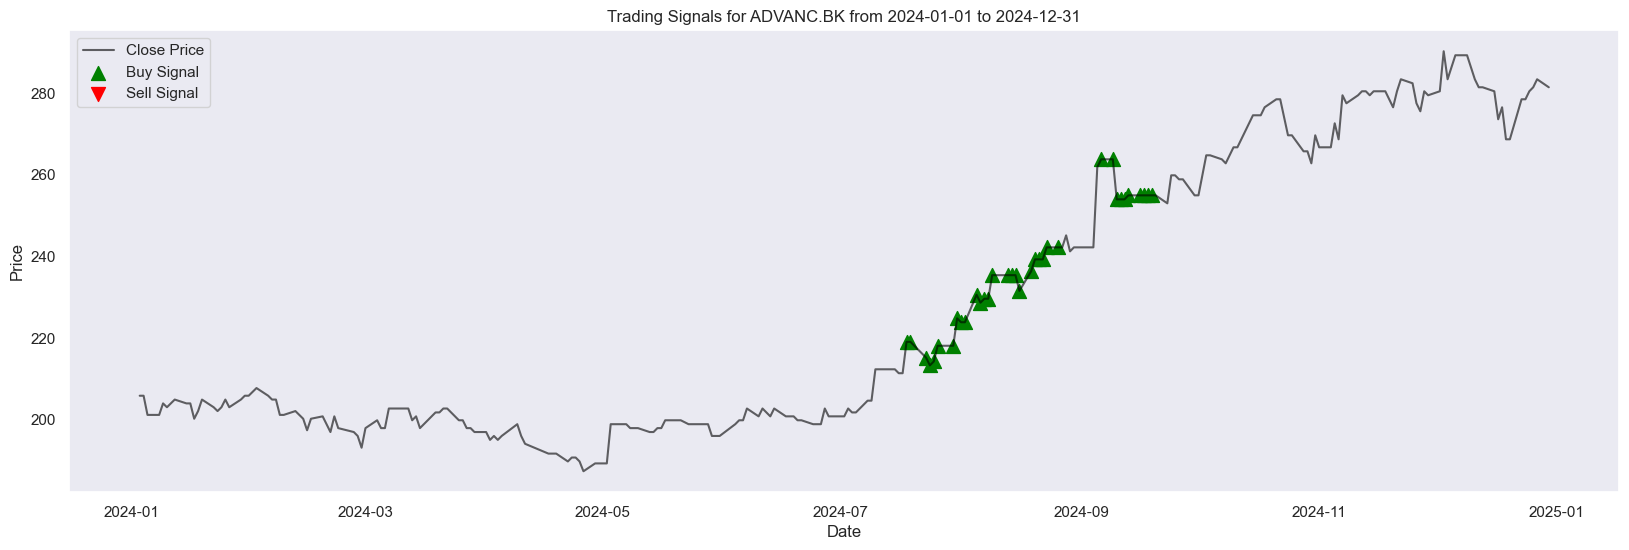

Text(0.5, 0, 'Time')

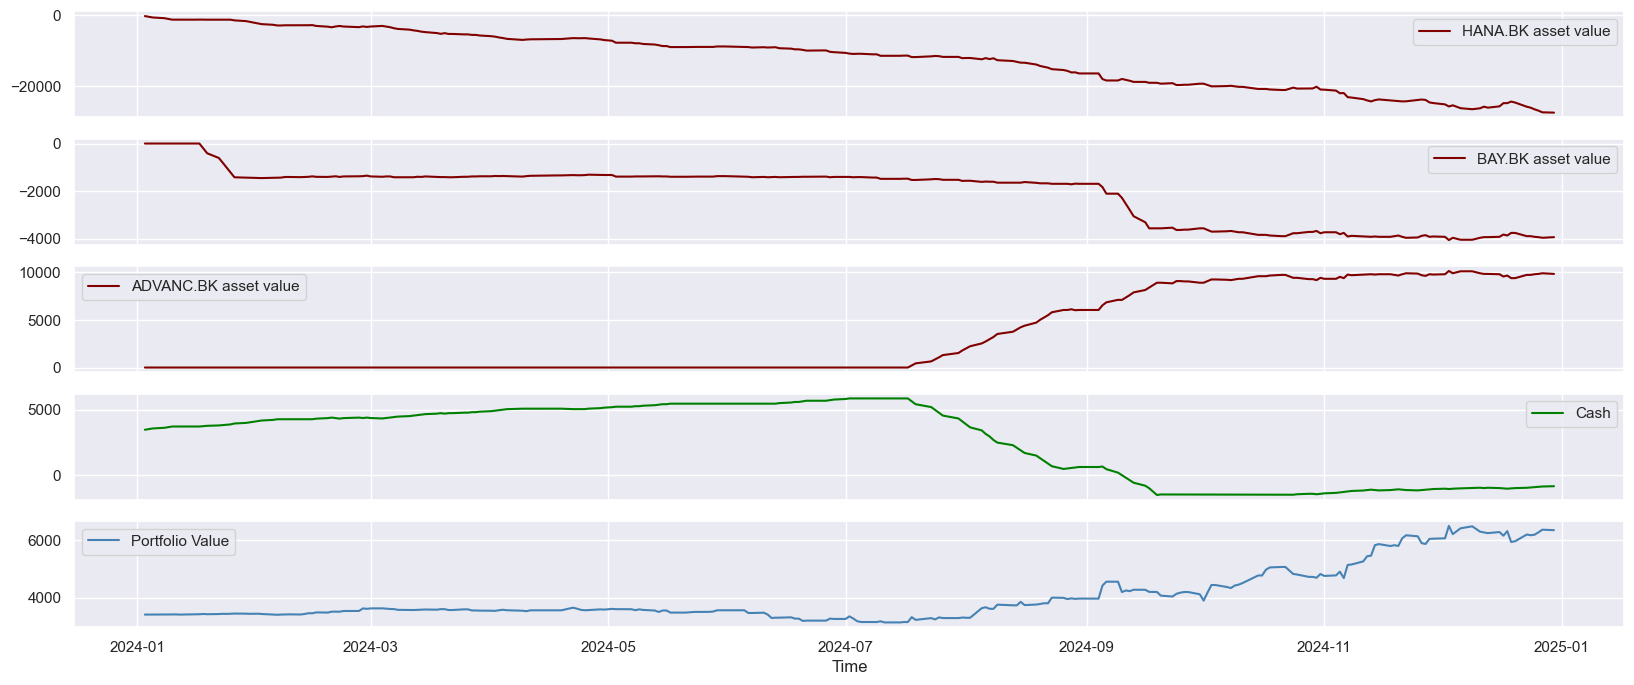

{'HANA.BK': 22.22816472474174, 'BAY.BK': 41.63396115908093, 'ADVANC.BK': 5.538127897172979}


<Figure size 2000x600 with 0 Axes>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

Text(0.5, 0, 'Returns')

Text(0, 0.5, 'Density')

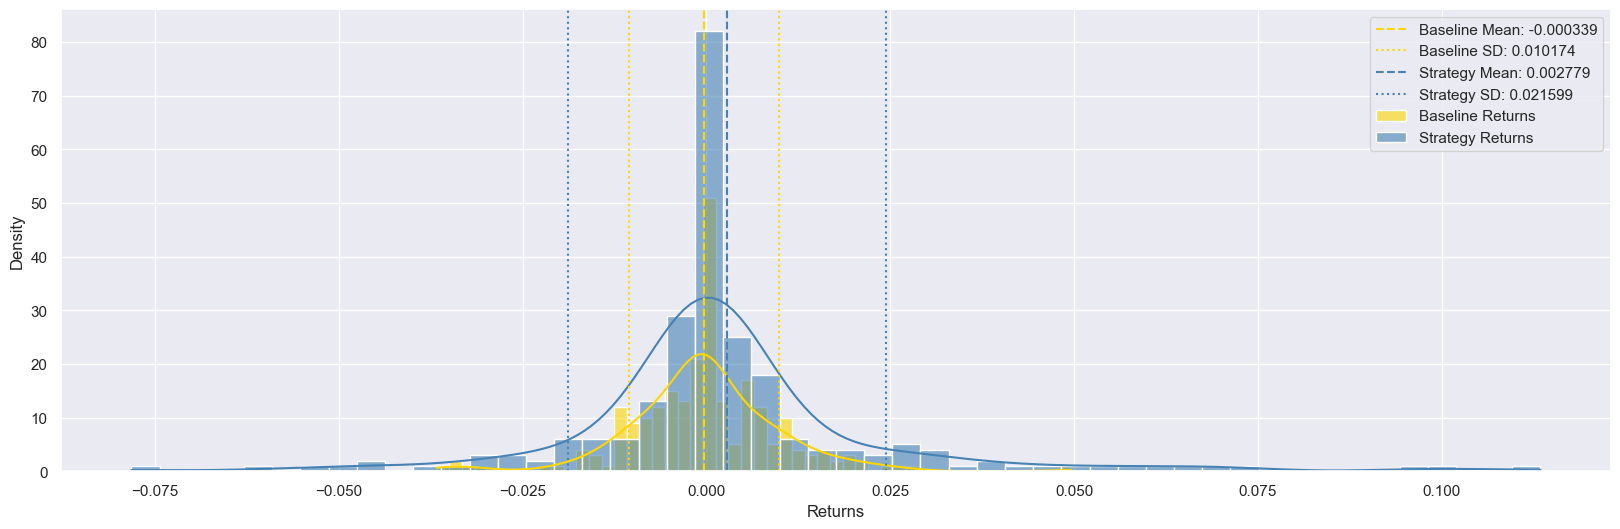

<Figure size 2000x800 with 0 Axes>

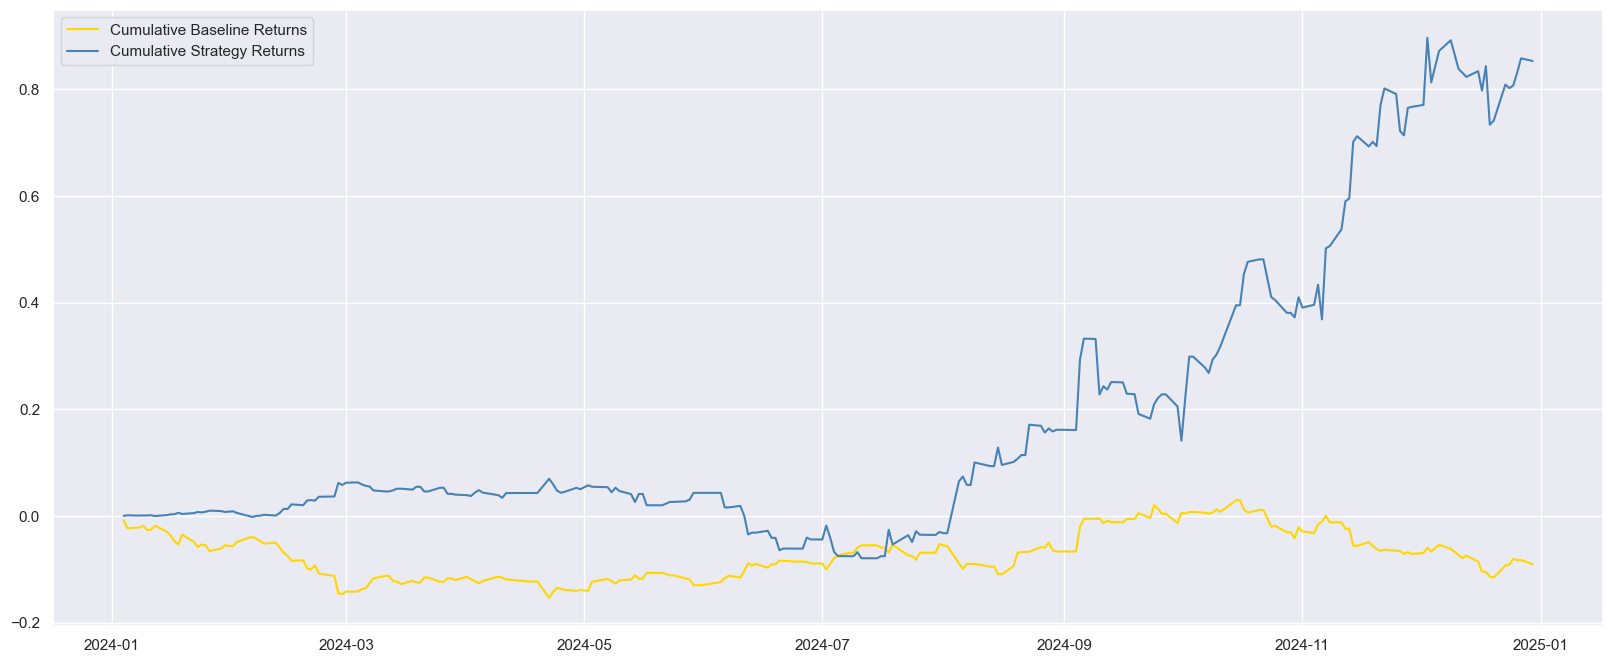

Final Portfolio Values
Baseline: 3111.44 THB
Our Strategy: 6336.26 THB
Equivalent Annual Returns
Baseline: -9.05%
Our Strategy: 85.58%


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-05   2024-01-05
End Period                 2024-12-30   2024-12-30
Risk-Free Rate             2.0%         2.0%
Time in Market             85.0%        100.0%

Cumulative Return          -8.31%       85.2%
CAGR﹪                     -5.9%        53.94%

Sharpe                     -0.6         1.99
Prob. Sharpe Ratio         21.83%       96.67%
Smart Sharpe               -0.56        1.83
Sortino                    -0.84        3.7
Smart Sortino              -0.77        3.41
Sortino/√2                 -0.59        2.62
Smart Sortino/√2           -0.55        2.41
Omega                      1.6          1.6

Max Drawdown               -14.07%      -14.36%
Longest DD Days            235          105
Volatility (ann.)          16.17%       34.36%
R^2                        0.0          0.0
Information Ratio          0.13         0.13
Calmar                 

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-09-09  2024-10-01  2024-10-11    33    -14.362717        -11.258722
2  2024-04-23  2024-07-15  2024-08-05   105    -13.927606        -13.920507
3  2024-12-04  2024-12-19  2024-12-30    27     -8.592052         -8.191092
4  2024-10-22  2024-11-06  2024-11-06    16     -7.597509         -7.342063
5  2024-11-25  2024-11-27  2024-12-02     8     -4.878925         -4.427341

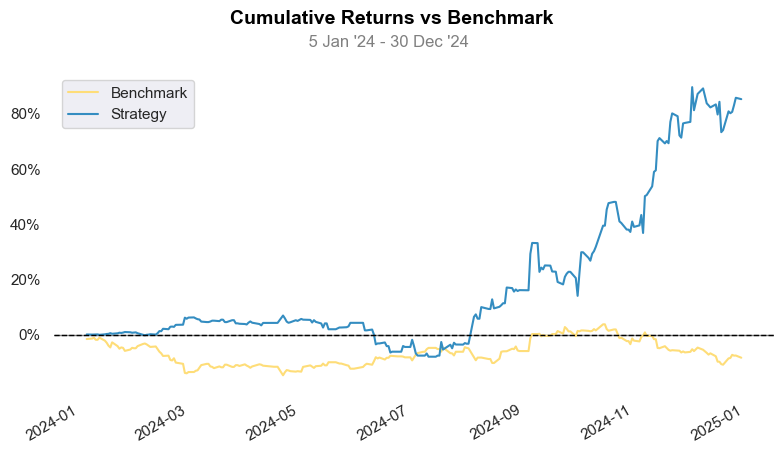

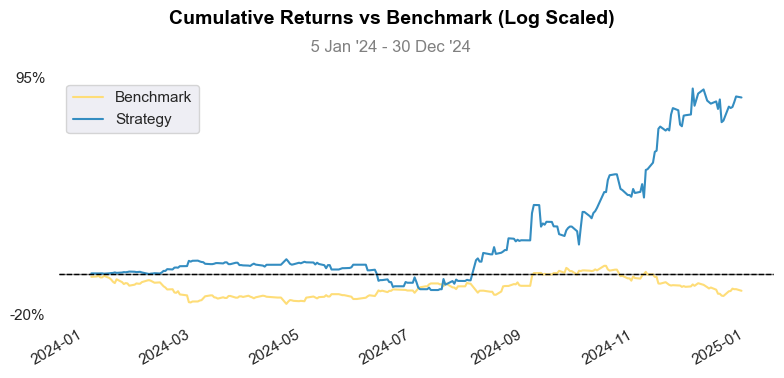

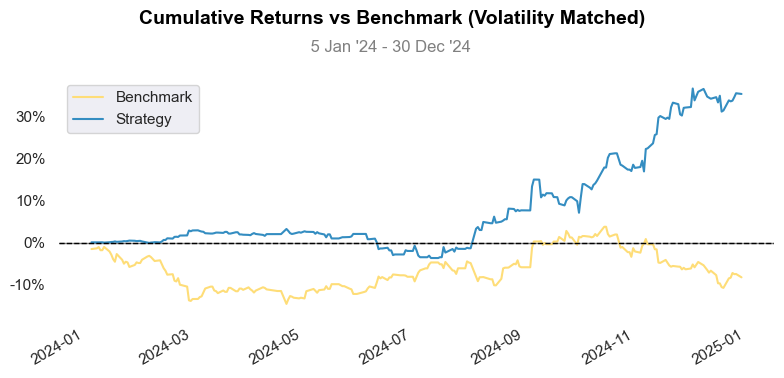

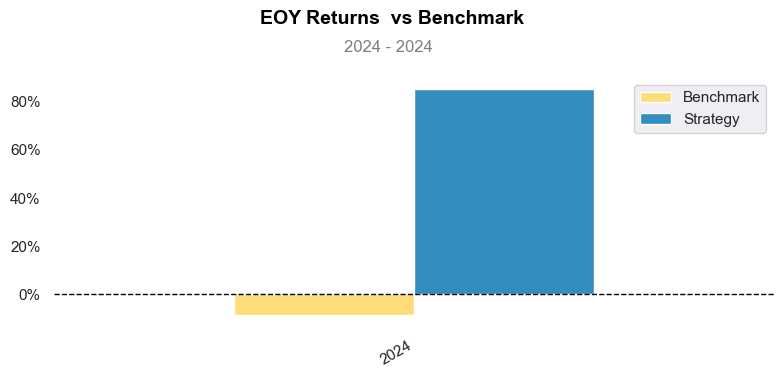

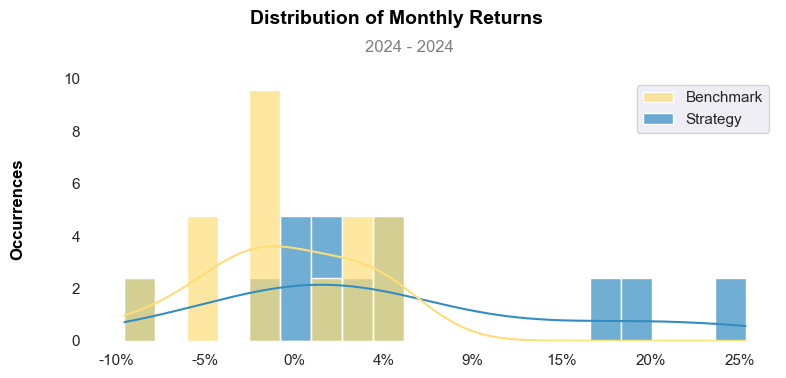

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/quantstats/_plotting/core.py:294: FutureWarning:

Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.



UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [863]:
y_pred = generate_trading_signals('2024-01-01', '2024-12-31')
custom_period = slice('2024-01-01', '2024-12-31')
X_custom = {asset: X_selected[asset].loc[custom_period] for asset in asset_list}
df1 = simulate_strategy(X_custom, y_pred)  

fig, axes = plt.subplots(len(asset_list)+2, 1, figsize=(20, 8), sharex=True)

for i in range(len(asset_list)):
  axes[i].plot(df1[('Asset',asset_list[i])]*df1[('Close',asset)], label=asset_list[i]+' asset value', color='maroon')
  axes[i].legend()

axes[len(asset_list)].plot(df1['Cash'], label='Cash', color='green')
axes[len(asset_list)].legend()

axes[len(asset_list)+1].plot(df1['Portfolio Value'], label='Portfolio Value', color='steelblue')
axes[len(asset_list)+1].legend()

plt.xlabel('Time')
plt.show()

# Implement baseline strategy
# Determine the initial amount of each asset so that the values of all assets in the initial portfolio are equal
asset_amount = {asset: initial_cash/len(asset_list)/X_custom[asset]['Close'].iloc[0] for asset in asset_list}
print(asset_amount)

# Calculate the daily returns of the baseline strategy
df1['Baseline Value'] = np.sum([X_custom[asset]['Close']*asset_amount[asset] for asset in asset_list], axis=0)
df1['Baseline Returns'] = df1['Baseline Value'].pct_change(1)

# Calculate the average and standard deviation
baseline_mean = df1['Baseline Returns'].mean()
baseline_std = df1['Baseline Returns'].std()

strategy_mean = df1['Strategy Returns'].mean()
strategy_std = df1['Strategy Returns'].std()

plt.figure(figsize=(20, 6))

# Plot histograms with KDE curves for Baseline Returns and Strategy Returns
sns.histplot(df1['Baseline Returns'], bins=50, kde=True, color='gold', label='Baseline Returns', alpha=0.6)
sns.histplot(df1['Strategy Returns'], bins=50, kde=True, color='steelblue', label='Strategy Returns', alpha=0.6)

# Add vertical lines for mean and standard deviation
plt.axvline(baseline_mean, color='gold', linestyle='--', label=f'Baseline Mean: {baseline_mean:.6f}')
plt.axvline(baseline_mean + baseline_std, color='gold', linestyle=':', label=f'Baseline SD: {baseline_std:.6f}')
plt.axvline(baseline_mean - baseline_std, color='gold', linestyle=':')
plt.axvline(strategy_mean, color='steelblue', linestyle='--', label=f'Strategy Mean: {strategy_mean:.6f}')
plt.axvline(strategy_mean + strategy_std, color='steelblue', linestyle=':', label=f'Strategy SD: {strategy_std:.6f}')
plt.axvline(strategy_mean - strategy_std, color='steelblue', linestyle=':')

# Adding labels and legend
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

# Calculate cumulative log returns
df1['Cumulative Baseline Returns'] = (1 + df1['Baseline Returns']).cumprod()-1
df1['Cumulative Strategy Returns'] = (1 + df1['Strategy Returns']).cumprod()-1

# Plot cumulative returns
plt.figure(figsize=(20, 8))
plt.plot(df1['Cumulative Baseline Returns'], label='Cumulative Baseline Returns', color='gold')
plt.plot(df1['Cumulative Strategy Returns'], label='Cumulative Strategy Returns', color='steelblue')
plt.legend()
plt.show()

print("Final Portfolio Values")
baseline_final_value = initial_cash*(1+df1['Cumulative Baseline Returns'].iloc[-1])
strategy_final_value = initial_cash*(1+df1['Cumulative Strategy Returns'].iloc[-1])
print("Baseline: {:.2f} THB".format(baseline_final_value))
print("Our Strategy: {:.2f} THB".format(strategy_final_value))

print("Equivalent Annual Returns")
days_count = df1['days_diff'].iloc[-N_test+1:].sum()+1
baseline_equivalent_rate = (baseline_final_value/initial_cash)**(365/days_count)-1
strategy_equivalent_rate = (strategy_final_value/initial_cash)**(365/days_count)-1
print("Baseline: {:.2f}%".format(baseline_equivalent_rate*100))
print("Our Strategy: {:.2f}%".format(strategy_equivalent_rate*100))

# Full report
qs.reports.full(df1['Strategy Returns'], df1['Baseline Returns'], rf=risk_free_rate)

## Period 3

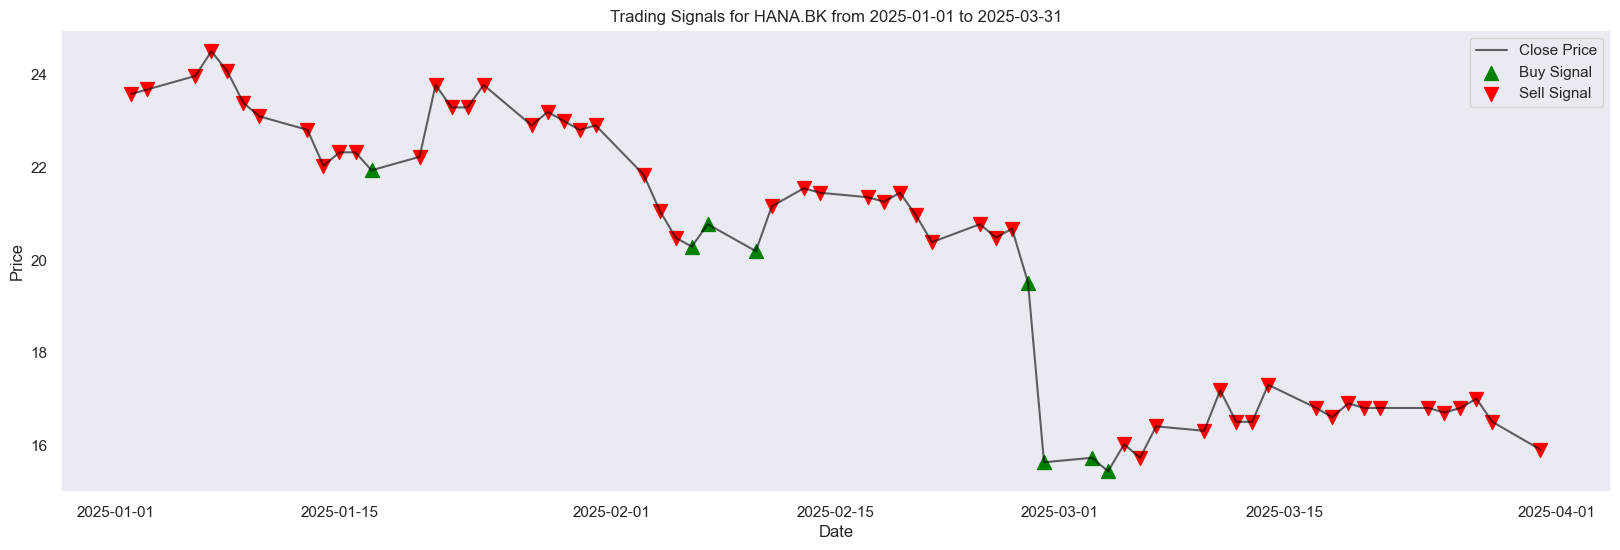

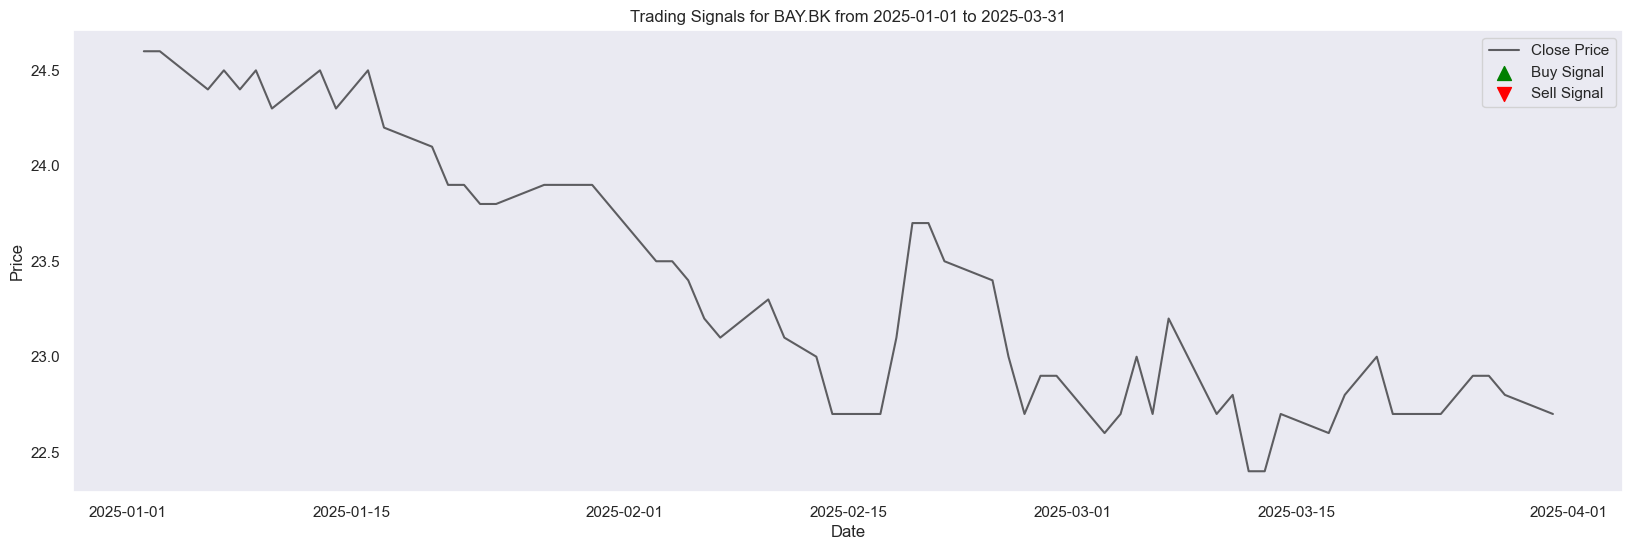

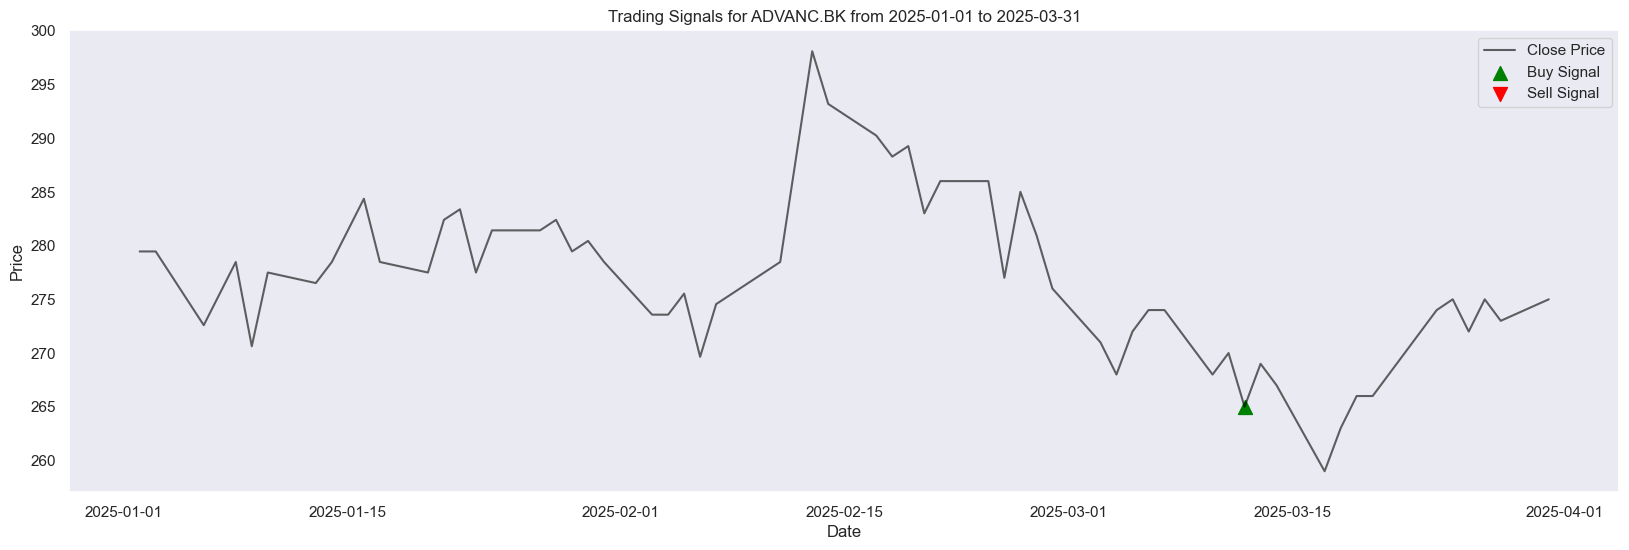

Text(0.5, 0, 'Time')

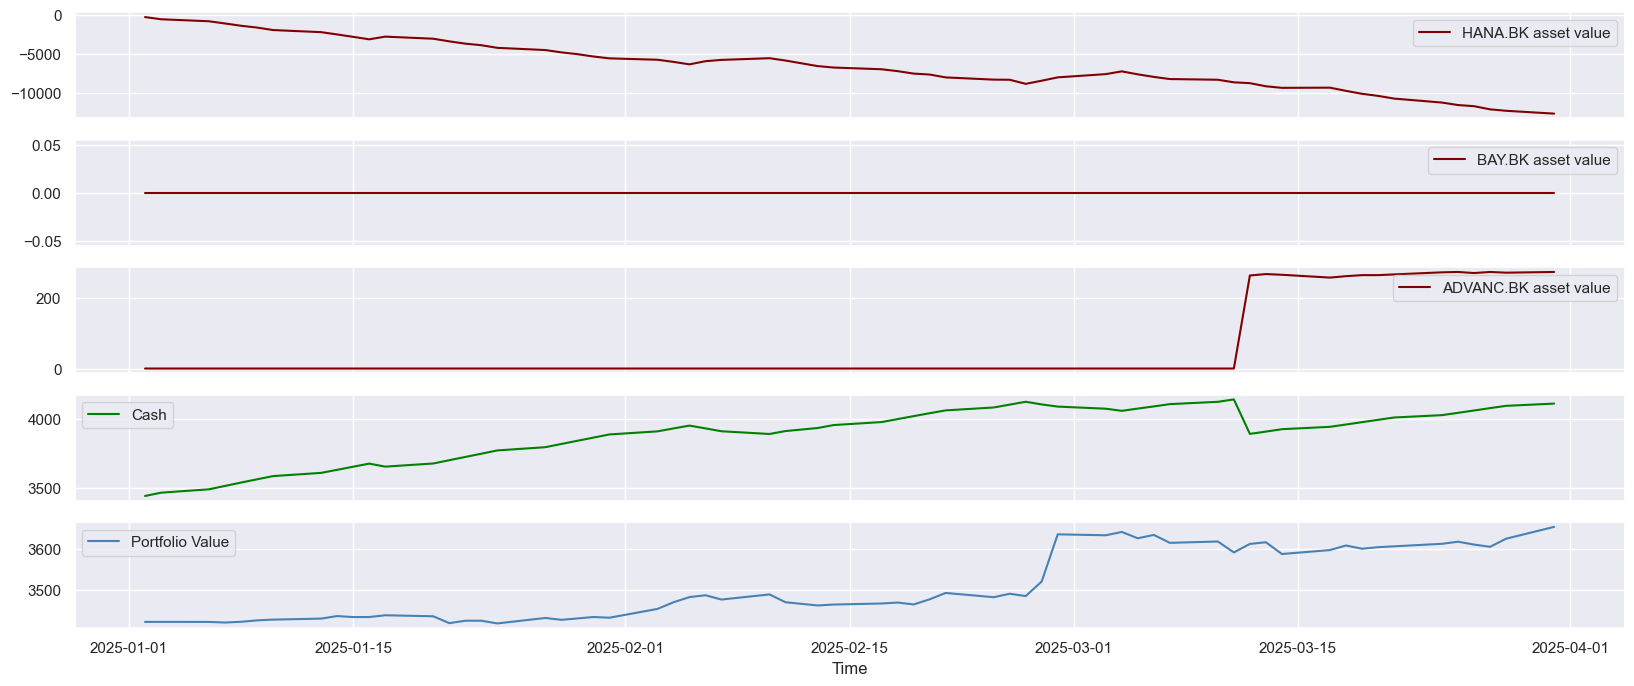

{'HANA.BK': 48.335206557995384, 'BAY.BK': 46.34146269602175, 'ADVANC.BK': 4.079375204143378}


<Figure size 2000x600 with 0 Axes>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

<Axes: xlabel='Baseline Returns', ylabel='Count'>

Text(0.5, 0, 'Returns')

Text(0, 0.5, 'Density')

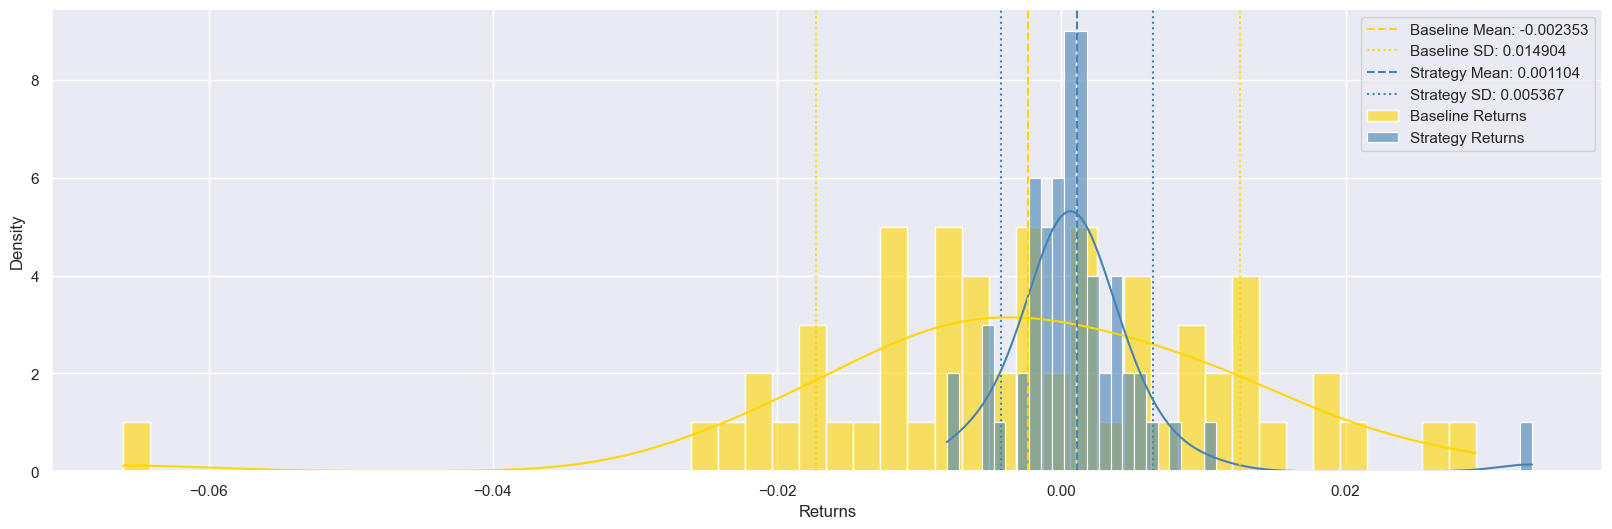

<Figure size 2000x800 with 0 Axes>

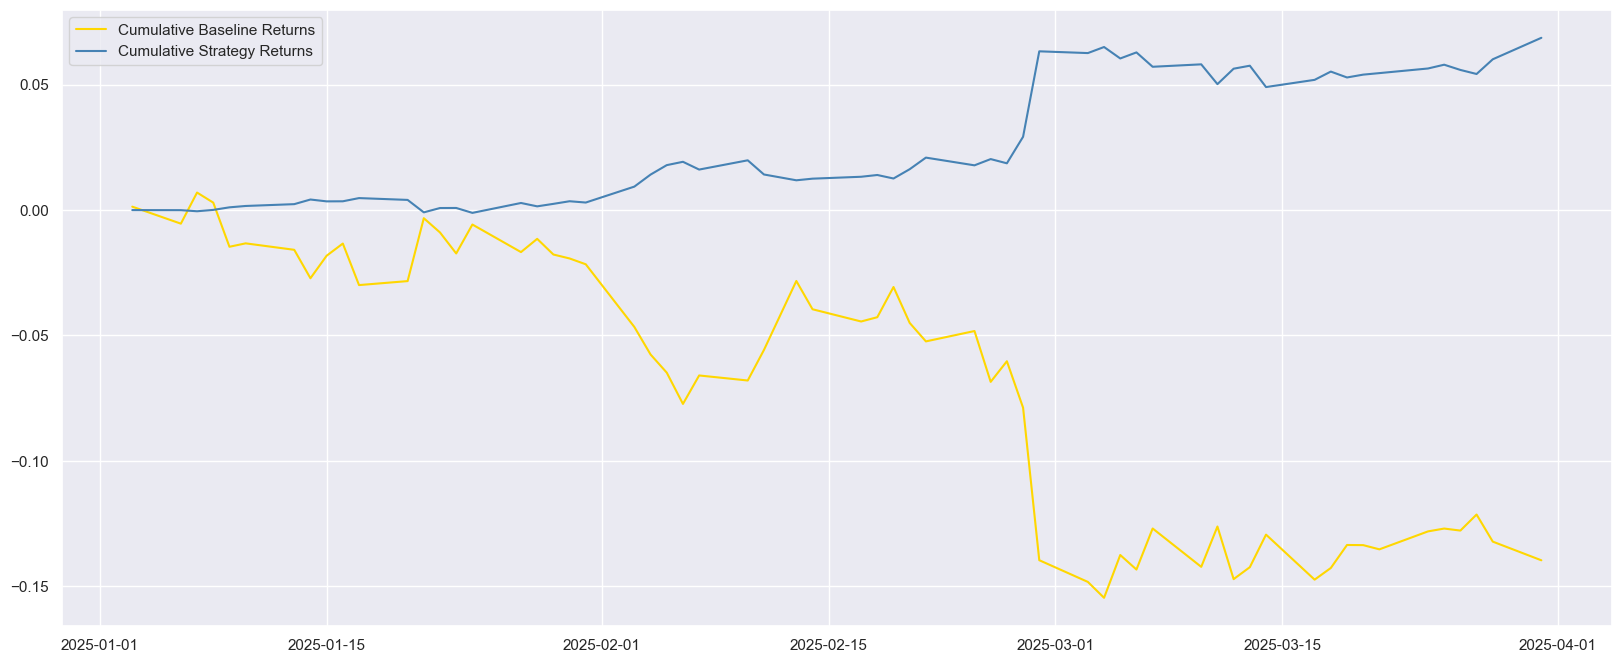

Final Portfolio Values
Baseline: 2942.31 THB
Our Strategy: 3655.01 THB
Equivalent Annual Returns
Baseline: -45.67%
Our Strategy: 30.93%


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2025-01-06   2025-01-06
End Period                 2025-03-31   2025-03-31
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          -14.09%      6.87%
CAGR﹪                     -36.58%      22.06%

Sharpe                     -2.63        3.06
Prob. Sharpe Ratio         6.66%        98.09%
Smart Sharpe               -2.41        2.8
Sortino                    -3.14        7.68
Smart Sortino              -2.86        7.01
Sortino/√2                 -2.22        5.43
Smart Sortino/√2           -2.03        4.96
Omega                      2.03         2.03

Max Drawdown               -16.05%      -1.5%
Longest DD Days            83           24
Volatility (ann.)          23.85%       8.59%
R^2                        0.69         0.69
Information Ratio          0.18         0.18
Calmar                   

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2025-03-05  2025-03-14  2025-03-28    24     -1.499488         -1.389662
2  2025-02-11  2025-02-13  2025-02-20    10     -0.781269         -0.717753
3  2025-01-20  2025-01-24  2025-01-31    12     -0.587128         -0.566550
4  2025-02-07  2025-02-07  2025-02-07     1     -0.303849               NaN
5  2025-02-24  2025-02-24  2025-02-26     3     -0.301513         -0.222388

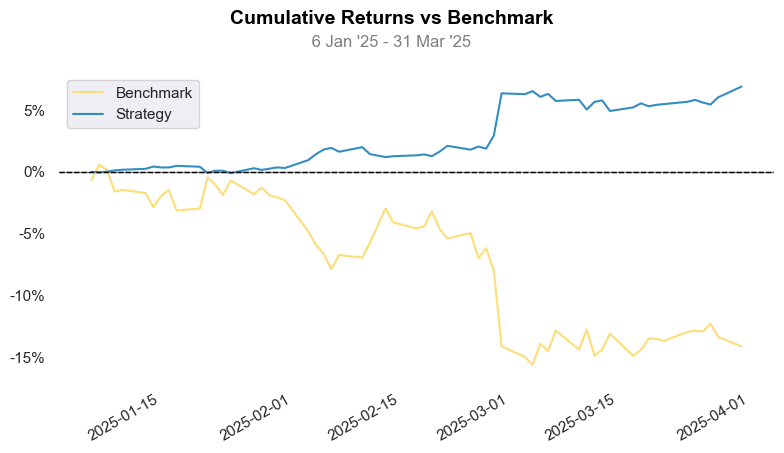

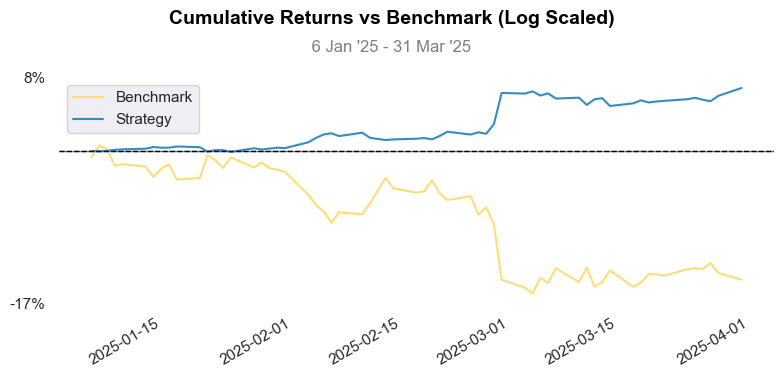

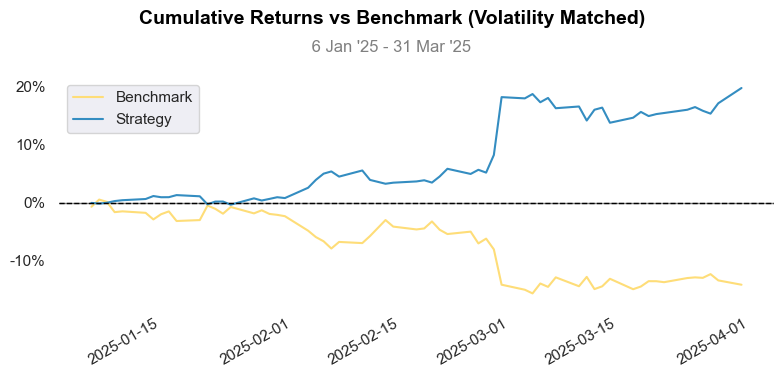

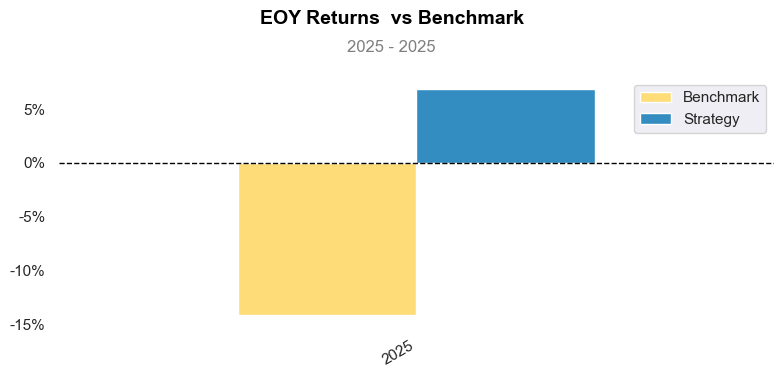

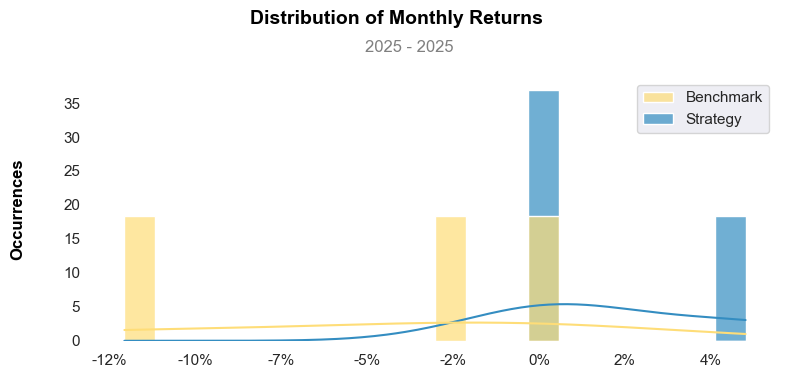

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/quantstats/_plotting/core.py:294: FutureWarning:

Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.



UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [864]:
y_pred = generate_trading_signals('2025-01-01', '2025-03-31')
custom_period = slice('2025-01-01', '2025-03-31')
X_custom = {asset: X_selected[asset].loc[custom_period] for asset in asset_list}
df1 = simulate_strategy(X_custom, y_pred)  

fig, axes = plt.subplots(len(asset_list)+2, 1, figsize=(20, 8), sharex=True)

for i in range(len(asset_list)):
  axes[i].plot(df1[('Asset',asset_list[i])]*df1[('Close',asset)], label=asset_list[i]+' asset value', color='maroon')
  axes[i].legend()

axes[len(asset_list)].plot(df1['Cash'], label='Cash', color='green')
axes[len(asset_list)].legend()

axes[len(asset_list)+1].plot(df1['Portfolio Value'], label='Portfolio Value', color='steelblue')
axes[len(asset_list)+1].legend()

plt.xlabel('Time')
plt.show()

# Implement baseline strategy
# Determine the initial amount of each asset so that the values of all assets in the initial portfolio are equal
asset_amount = {asset: initial_cash/len(asset_list)/X_custom[asset]['Close'].iloc[0] for asset in asset_list}
print(asset_amount)

# Calculate the daily returns of the baseline strategy
df1['Baseline Value'] = np.sum([X_custom[asset]['Close']*asset_amount[asset] for asset in asset_list], axis=0)
df1['Baseline Returns'] = df1['Baseline Value'].pct_change(1)

# Calculate the average and standard deviation
baseline_mean = df1['Baseline Returns'].mean()
baseline_std = df1['Baseline Returns'].std()

strategy_mean = df1['Strategy Returns'].mean()
strategy_std = df1['Strategy Returns'].std()

plt.figure(figsize=(20, 6))

# Plot histograms with KDE curves for Baseline Returns and Strategy Returns
sns.histplot(df1['Baseline Returns'], bins=50, kde=True, color='gold', label='Baseline Returns', alpha=0.6)
sns.histplot(df1['Strategy Returns'], bins=50, kde=True, color='steelblue', label='Strategy Returns', alpha=0.6)

# Add vertical lines for mean and standard deviation
plt.axvline(baseline_mean, color='gold', linestyle='--', label=f'Baseline Mean: {baseline_mean:.6f}')
plt.axvline(baseline_mean + baseline_std, color='gold', linestyle=':', label=f'Baseline SD: {baseline_std:.6f}')
plt.axvline(baseline_mean - baseline_std, color='gold', linestyle=':')
plt.axvline(strategy_mean, color='steelblue', linestyle='--', label=f'Strategy Mean: {strategy_mean:.6f}')
plt.axvline(strategy_mean + strategy_std, color='steelblue', linestyle=':', label=f'Strategy SD: {strategy_std:.6f}')
plt.axvline(strategy_mean - strategy_std, color='steelblue', linestyle=':')

# Adding labels and legend
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

# Calculate cumulative log returns
df1['Cumulative Baseline Returns'] = (1 + df1['Baseline Returns']).cumprod()-1
df1['Cumulative Strategy Returns'] = (1 + df1['Strategy Returns']).cumprod()-1

# Plot cumulative returns
plt.figure(figsize=(20, 8))
plt.plot(df1['Cumulative Baseline Returns'], label='Cumulative Baseline Returns', color='gold')
plt.plot(df1['Cumulative Strategy Returns'], label='Cumulative Strategy Returns', color='steelblue')
plt.legend()
plt.show()

print("Final Portfolio Values")
baseline_final_value = initial_cash*(1+df1['Cumulative Baseline Returns'].iloc[-1])
strategy_final_value = initial_cash*(1+df1['Cumulative Strategy Returns'].iloc[-1])
print("Baseline: {:.2f} THB".format(baseline_final_value))
print("Our Strategy: {:.2f} THB".format(strategy_final_value))

print("Equivalent Annual Returns")
days_count = df1['days_diff'].iloc[-N_test+1:].sum()+1
baseline_equivalent_rate = (baseline_final_value/initial_cash)**(365/days_count)-1
strategy_equivalent_rate = (strategy_final_value/initial_cash)**(365/days_count)-1
print("Baseline: {:.2f}%".format(baseline_equivalent_rate*100))
print("Our Strategy: {:.2f}%".format(strategy_equivalent_rate*100))

# Full report
qs.reports.full(df1['Strategy Returns'], df1['Baseline Returns'], rf=risk_free_rate)

## Conclusion <br>
This project implemented a machine learning-driven algorithmic trading strategy applied to 3 assets: HANA.BK, BBL.BK, ADVANC.BK.<br>
The suitable model for each asset <br>
- HANA.BK &nbsp; &nbsp; &nbsp;: Tuned RandomForestClassifier (Accuracy: 0.3657)
- BAY.BK &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;: Tuned DecisionTreeClassifier (Accuracy: 0.4641)
- ADVANC.BK &nbsp;: Tuned DecisionTreeClassifier (Accuracy: 0.4135)<br>

The strategy was evaluated over three distinct historical periods to assess its performance and adaptability across different market conditions.
- Period 1 (2022-01-01 to 2022-06-30):  
  - CAGR: -0.01%  
  - Cumulative Return: 0.0%
  - Beat Benchmark : Yes
  
- Period 2 (2024-01-01 to 2024-12-31):  
  - CAGR: 53.94% 
  - Cumulative Return: 85.2%
  - Beat Benchmark : Yes

- Period 3 (2025-01-01 to 2025-03-31):  
  - CAGR: 22.06%  
  - Cumulative Return:  6.87%
  - Beat Benchmark : Yes
## Key Insights: <br>
- Pandas_ta (Technical Analysis) can be used to create more feature such as RSI, CMF, and other indicators, conveniently.
- An appropriate threshold adjustment could help us balance the feature's distribution.

## Areas for Improvement:<br>
- Use machine learning to dynnamically adjust indicator's best range.
- Showing the confident level of the signal